## **`Data cleaning`**

In [1]:
# import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import RobustScaler

In [2]:
# load data

url = "https://raw.githubusercontent.com/dhieu0901/DSEB65A_MachineLearningProject_Group5/main/data/Hanoi%20Daily%2010%20years.csv"
df = pd.read_csv(url)



## **`Handling missing values for time-series problem`**

In [3]:
# handling Missing Values

def check_missing_values(df):
    """Return missing percentage for each column."""
    missing = df.isnull().mean() * 100
    return missing[missing > 0].sort_values(ascending=False)

missing_ratio = check_missing_values(df)
print("\nMissing Value Ratio (%):")
print(missing_ratio)

# focus on specific columns
if 'severerisk' in df.columns:
    print(f"\nsevererisk missing: {missing_ratio['severerisk']:.2f}%")
if 'preciptype' in df.columns:
    print(f"preciptype missing: {missing_ratio['preciptype']:.2f}%")


Missing Value Ratio (%):
severerisk    72.677596
preciptype    26.967213
dtype: float64

severerisk missing: 72.68%
preciptype missing: 26.97%


## **`Dropping redundant and zero-variance cols`**

In [4]:
# Constant and Zero-Variance Columns

def find_constant_columns(df):
    """Find columns with only one unique (non-null) value."""
    # This also finds numeric columns with zero variance
    return [col for col in df.columns if df[col].nunique(dropna=True) <= 1]

# find all constant columns
constant_cols = find_constant_columns(df)
print("\nConstant or Zero-Variance Columns Detected:")
print(constant_cols)

# (domain knowledge) other potential cols that should be dropped for future refactor
other_cols_to_drop = ['address', 'resolvedAddress', 'source', 'latitude', 'longitude', 'severerisk', 'stations']

# combine the lists and remove duplicates -> use set
all_cols_to_drop = list(set(constant_cols + other_cols_to_drop))

print("\nFull list of columns to be dropped:")
print(all_cols_to_drop)

# 4. drop the columns that actually exist in the dataframe
# PLEASE note that from now on we only process with cleaned_df for better later debugging
cleaned_df = df.drop(columns=[c for c in all_cols_to_drop if c in df.columns], errors='ignore')


Constant or Zero-Variance Columns Detected:
['name', 'preciptype', 'snow', 'snowdepth']

Full list of columns to be dropped:
['snow', 'resolvedAddress', 'address', 'source', 'snowdepth', 'preciptype', 'longitude', 'name', 'latitude', 'stations', 'severerisk']


## **`Correcting Data Types`**

##### **Converting to timestamp datatype for time-series analysis**

In [5]:
# convert to timestamp data type
cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])
cleaned_df['sunrise'] = pd.to_datetime(cleaned_df['sunrise'])
cleaned_df['sunset'] = pd.to_datetime(cleaned_df['sunset'])

In [6]:
# multi-label cols processing
# split 'condition' col into binary cols (sep=',')
conditions_dummies = cleaned_df['conditions'].str.get_dummies(sep=', ')

# concat to the processing dataframe
cleaned_df = pd.concat([cleaned_df, conditions_dummies], axis=1)

# now the original
cleaned_df.drop('conditions', axis=1, inplace=True)

# we can and must also drop df['description'],
# because it is just the more complicated version of df['condition'] which we have already handled
cleaned_df.drop('description', axis=1, inplace=True)

##### **One-hot Encoding**

The `icon` column is of object type and needs to be transformed into a numeric format for machine learning models. To do this, we apply **One-Hot Encoding**, a technique that converts categorical data into binary vectors.

This transformation ensures the model can process the data numerically and treat each icon category as a separate feature.


In [7]:
# apply one-hot encoding
icon_dummies = pd.get_dummies(cleaned_df['icon'], prefix='icon')

# concat
cleaned_df = pd.concat([cleaned_df, icon_dummies], axis=1)

# drop orignal one
cleaned_df.drop('icon', axis=1, inplace=True)

## **`Main: Feature Engineering`**

Feature Engineering is a critical phase of this project, designed to extract and construct informative features from the raw time-series data. This process aims to capture the complex temporal patterns, cyclical behaviors, and physical relationships inherent in meteorological data, thereby maximizing the predictive power of our machine learning models.

The process is organized into several key stages, from basic temporal decomposition to advanced signal processing.

### **4.1. Temporal and Calendar-Based Features**

**4.1.1.** **`Basic Temporal Decomposition`**

We first extract standard calendar components to provide the model with a clear understanding of annual, monthly, and weekly cycles.

- `month`, `day_of_year`, `day_of_week`, `week_of_year`, `year`, `quarter`, `day_of_month`

In [8]:
# ADJUSTED

# Các thành phần thời gian cơ bản (Decomposition)
cleaned_df['month'] = cleaned_df['datetime'].dt.month
cleaned_df['day_of_year'] = cleaned_df['datetime'].dt.dayofyear
cleaned_df['day_of_week'] = cleaned_df['datetime'].dt.dayofweek
cleaned_df['week_of_year'] = cleaned_df['datetime'].dt.isocalendar().week.astype(int)
cleaned_df['year'] = cleaned_df['datetime'].dt.year
cleaned_df['quarter'] = cleaned_df['datetime'].dt.quarter  # quarter
cleaned_df['day_of_month'] = cleaned_df['datetime'].dt.day  # day of month


**4.1.2.** **`Event and Seasonality Indicators`**

To capture specific events and seasonal blocks, we created:

- `is_weekend`: A binary flag (1 for Saturday/Sunday, 0 otherwise) to model potential changes in human activity that might affect local temperatures.

- `is_holiday`: A binary flag (1 if the date is a public holiday in Vietnam, 0 otherwise). This was generated using the `holidays.VN` library to capture non-periodic, event-based anomalies.

Season Features: A categorical `season` feature ('Winter', 'Spring', 'Summer', 'Fall') was created. This was then One-Hot Encoded into four binary columns (`season_Winter`, `season_Spring`, etc.) to allow the model to learn distinct effects for each season without assuming an ordinal relationship.

In [9]:
# NEW
import holidays

cleaned_df['is_weekend'] = cleaned_df['day_of_week'].isin([5, 6]).astype(int)  # binary

# Thêm holiday indicators (Binary cho holiday)
# cho nay dung holidays.VN de trich xuat cac ngay le o vn
vn_holidays = holidays.VN(years=range(cleaned_df['year'].min(), cleaned_df['year'].max() + 1))
cleaned_df['is_holiday'] = cleaned_df['datetime'].apply(lambda x: 1 if x in vn_holidays else 0)

# Feature mùa và mã hóa one-hot (Season Indicators)
def get_season(month):
    if month in [12, 1, 2]: return 'Winter'
    elif month in [3, 4, 5]: return 'Spring'
    elif month in [6, 7, 8]: return 'Summer'
    else: return 'Fall'
cleaned_df['season'] = cleaned_df['month'].apply(get_season)
season_dummies = pd.get_dummies(cleaned_df['season'], prefix='season')
cleaned_df = pd.concat([cleaned_df, season_dummies], axis=1)

### **4.2. Domain-Specific and Physical Features**

These features are derived from domain knowledge of meteorology and physics to represent tangible environmental factors.

`daylight_duration_sec`: Calculated as the total seconds between `sunrise` and `sunset`. This feature is a strong proxy for the total solar energy received on a given day, a primary driver of temperature.

`temp_range`: The difference between `tempmax` and `tempmin`, representing the diurnal temperature variation.

`dew_point_depression`: The difference between `temp` and `dew` (dew point). This is a measure of relative humidity; a smaller difference indicates higher humidity.

In [10]:
# Daylight duration (Domain-specific decomposition)
cleaned_df['daylight_duration_sec'] = (cleaned_df['sunset'] - cleaned_df['sunrise']).dt.total_seconds()
cleaned_df['daylight_duration_sec'].fillna(0, inplace=True)  # handle NaN

# Biên độ nhiệt trong ngày
cleaned_df['temp_range'] = cleaned_df['tempmax'] - cleaned_df['tempmin']
# Độ bão hòa hơi nước
cleaned_df['dew_point_depression'] = cleaned_df['temp'] - cleaned_df['dew']

C:\Users\duong\AppData\Local\Temp\ipykernel_15444\2005540812.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  cleaned_df['daylight_duration_sec'].fillna(0, inplace=True)  # handle NaN


### **4.3. Time-Series Decomposition (STL)**

To isolate the core components of the target variable (`temp`), we applied Seasonal-Trend decomposition using **LOESS (STL)**. This technique is highly robust and separates the time series into three components, which were added as new features:

- `temp_trend_yearly`: The long-term trend (using a 365-day period), capturing slow-moving changes in temperature (e.g., climate change).

- `temp_seasonal_yearly`: The primary seasonal cycle.

- `temp_resid_yearly`: The residual component (i.e., `temp` - `trend` - `seasonal`), which represents the noise or high-frequency variability not captured by the main cycles.

These components allow the model to learn the trend and seasonality separately from the short-term fluctuations.

In [11]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf  # Để check resid

# Đảm bảo index là datetime và sorted (tích hợp từ code mới)
if 'datetime' in cleaned_df.columns:
    cleaned_df['datetime'] = pd.to_datetime(cleaned_df['datetime'])
    cleaned_df.set_index('datetime', inplace=True)
cleaned_df.sort_index(inplace=True)  # sort

# Chọn target, handle NaN ban đầu
series_to_decompose = cleaned_df['temp'].dropna()  # Hoặc fill nếu cần: .fillna(method='ffill')

# STL yearly
stl_yearly = STL(series_to_decompose, period=365, seasonal=13, robust=True)
result_yearly = stl_yearly.fit()

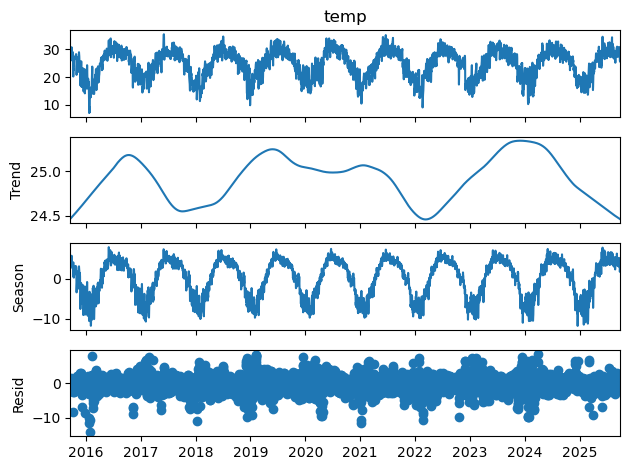

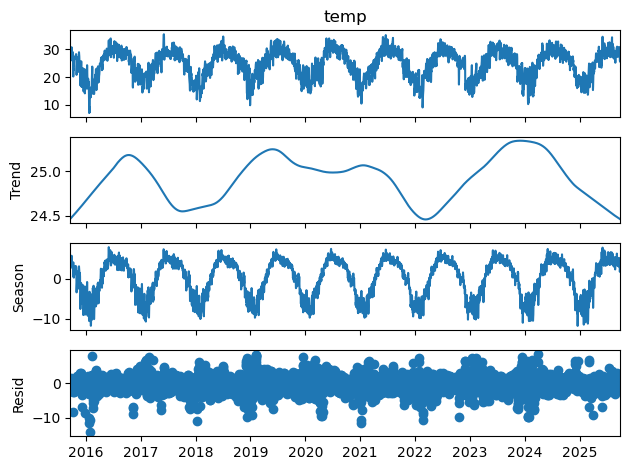

In [12]:
# concat
cleaned_df['temp_trend_yearly'] = result_yearly.trend
cleaned_df['temp_seasonal_yearly'] = result_yearly.seasonal
cleaned_df['temp_resid_yearly'] = result_yearly.resid
result_yearly.plot()

In [13]:
# Handle NaN sau decomposition
print("NaN in new features before handling:")
print(cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().sum())

if cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().any().any():
    # Forward/backward fill để giữ tính liên tục time series
    cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']] = \
        cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].fillna(method='ffill')
    cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']] = \
        cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].fillna(method='bfill')

print("NaN after handling:", cleaned_df[['temp_trend_yearly', 'temp_seasonal_yearly', 'temp_resid_yearly']].isna().sum().sum())

# Kiểm tra head
print(cleaned_df[['temp', 'temp_seasonal_yearly', 'temp_trend_yearly', 'temp_resid_yearly']].head())

NaN in new features before handling:
temp_trend_yearly       0
temp_seasonal_yearly    0
temp_resid_yearly       0
dtype: int64
NaN after handling: 0
            temp  temp_seasonal_yearly  temp_trend_yearly  temp_resid_yearly
datetime                                                                    
2015-09-20  29.3              4.610702          24.467468           0.221830
2015-09-21  26.8              3.172797          24.469298          -0.842094
2015-09-22  25.9              3.111623          24.471129          -1.682752
2015-09-23  28.0              3.536615          24.472963          -0.009578
2015-09-24  29.9              4.256419          24.474799           1.168782


### **4.4. Statistical and Lagged Features**

This group of features captures the autoregressive nature (i.e., self-dependency) of time-series data.

**4.4.1..** **`Lag and Difference Features`**


- Lag Features: We generated lag features (`_lag_X`) for key variables (`temp`, `humidity`, `windspeed`, `cloudcover`, `precip`). Lags represent the value of a variable at a previous time step.

- Difference Features: We created difference features (`_diff_X`) for 1-period and 7-period (*weekly*) changes. This helps the model capture the rate of change rather than just the absolute value.

In [14]:
# ADJUSTED

# Lag features
lag_cols = ['temp', 'humidity', 'windspeed', 'cloudcover', 'precip']
lags = [1, 2, 7, 30, 365]

for col in lag_cols:
    for lag in lags:
        cleaned_df[f'{col}_lag_{lag}'] = cleaned_df[col].shift(lag)
    cleaned_df[f'{col}_diff_1'] = cleaned_df[col].diff(periods=1)
    cleaned_df[f'{col}_diff_7'] = cleaned_df[col].diff(periods=7)

#### **4.4.2.** **`PACF-Based Lag Selection`**

Instead of arbitrarily selecting lags, we adopted a data-driven approach. We computed the **Partial Autocorrelation Function (PACF)** for each key variable. The PACF identifies the direct correlation between a time step and its lags, removing the influence of intervening lags.We then selected only the lags that showed a statistically significant partial autocorrelation (i.e., PACF value > $1.96 / \sqrt{n}$). This filtering process (e.g., `select_lags_based_on_pacf`) ensures that we only feed the most informative and non-redundant lags to the model, reducing noise and dimensionality.

In [15]:
# Chỉ giữ lại các lags có PACF vượt CI +-1.96/sqrt(n)
from statsmodels.tsa.stattools import pacf

# Hàm chọn lags dựa trên PACF
def select_lags_based_on_pacf(series, max_lags=365, threshold=None):  # Tăng max_lags
    series_clean = series.dropna()
    if threshold is None and len(series_clean) > 0:
        threshold = 1.96 / np.sqrt(len(series_clean))
    pacf_values = pacf(series_clean, nlags=max_lags, alpha=None)
    significant_lags = [lag for lag in range(1, len(pacf_values)) if abs(pacf_values[lag]) > threshold]
    return significant_lags[:5] if len(significant_lags) > 5 else significant_lags

# Áp dụng PACF
initial_lags = [1, 2, 7, 30, 365]
selected_lags = {}
discarded_lags = {}

for col in lag_cols:
    series = cleaned_df[col]
    lags = select_lags_based_on_pacf(series)
    selected_lags[col] = lags
    discarded_lags[col] = [lag for lag in initial_lags if lag not in lags]
    print(f"\nColumn: {col}")
    print(f"Significant lags kept: {selected_lags[col]}")
    print(f"Discarded lags: {discarded_lags[col]}")

# Tạo lại lag features
cleaned_df_adjusted = cleaned_df.copy()
for col in lag_cols:
    current_cols = [c for c in cleaned_df.columns if c.startswith(f'{col}_lag_')]
    cleaned_df_adjusted.drop(columns=current_cols, inplace=True)
    if selected_lags[col]:
        for lag in selected_lags[col]:
            cleaned_df_adjusted[f'{col}_lag_{lag}'] = cleaned_df[col].shift(lag)
    else:
        print(f"No significant lags for {col}, keeping original column.")


Column: temp
Significant lags kept: [1, 2, 3, 4, 5]
Discarded lags: [7, 30, 365]

Column: humidity
Significant lags kept: [1, 2, 3, 4, 9]
Discarded lags: [7, 30, 365]

Column: windspeed
Significant lags kept: [1, 3, 7, 8, 9]
Discarded lags: [2, 30, 365]

Column: cloudcover
Significant lags kept: [1, 2, 3, 4, 6]
Discarded lags: [7, 30, 365]

Column: precip
Significant lags kept: [1, 2, 3, 4, 5]
Discarded lags: [7, 30, 365]


#### **4.4.3.** **`Rolling and Expanding Statistics`**

To capture local trends and volatility, we generated rolling window and exponentially-weighted features.

  **Data Leakage Prevention**: All rolling statistics were calculated using `.shift(1)` on the original series. This ensures that statistics for a given day (t) are computed only using data available up to day (t-1), which is crucial for building a model that can generalize to new, unseen data.

- Rolling Statistics: We calculated `roll_mean`, `roll_std`, `roll_min`, `roll_max`, and `roll_sum` (for `precip`) over various windows (e.g., 3, 7, 14, 30 days).

- **Exponentially Weighted Moving Averages (EWMA)**: We generated EWMAs (`_ewm_X`) with different spans (e.g., 3, 7, 14, 30 days). EWMA assigns more weight to recent observations, making it highly responsive to recent changes.

### **4.5. Cyclical Feature Encoding**

Temporal features like `day_of_year` or `hour_of_day` are cyclical (e.g., 365 is close to 1; 23:00 is close to 00:00). To represent this ***wrap-around*** property, we transformed them into a 2D space using sine and cosine functions.

This was applied to:

`day_of_year`: `sin_day_of_year`, `cos_day_of_year`

`hour_of_day`: `sin_hour_of_day`, `cos_hour_of_day`

`winddir` (Wind Direction): `winddir_sin`, `winddir_cos`

`moonphase`: `moonphase_sin`, `moonphase_cos`

In [16]:
# NEW
# cyclical encoding
cleaned_df['day_of_year'] = cleaned_df.index.dayofyear
cleaned_df['sin_day_of_year'] = np.sin(2 * np.pi * cleaned_df['day_of_year'] / 365)
cleaned_df['cos_day_of_year'] = np.cos(2 * np.pi * cleaned_df['day_of_year'] / 365)

# same to hour_of_day
if cleaned_df.index.freq == 'H' or cleaned_df.index.freq == 'h':
    cleaned_df['hour_of_day'] = cleaned_df.index.hour
    cleaned_df['sin_hour_of_day'] = np.sin(2 * np.pi * cleaned_df['hour_of_day'] / 24)
    cleaned_df['cos_hour_of_day'] = np.cos(2 * np.pi * cleaned_df['hour_of_day'] / 24)

# Xử lý NaN
cleaned_df.fillna(method='bfill', inplace=True)
cleaned_df.fillna(method='ffill', inplace=True)

C:\Users\duong\AppData\Local\Temp\ipykernel_15444\1082448005.py:14: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='bfill', inplace=True)
C:\Users\duong\AppData\Local\Temp\ipykernel_15444\1082448005.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='ffill', inplace=True)


In [17]:
# Mã hóa hướng gió (0-360 độ)
cleaned_df['winddir_sin'] = np.sin(np.deg2rad(cleaned_df['winddir']))
cleaned_df['winddir_cos'] = np.cos(np.deg2rad(cleaned_df['winddir']))

# Mã hóa pha mặt trăng (0-1)
cleaned_df['moonphase_sin'] = np.sin(2 * np.pi * cleaned_df['moonphase'])
cleaned_df['moonphase_cos'] = np.cos(2 * np.pi * cleaned_df['moonphase'])

### **4.6. Advanced Feature Engineering**

This final set of features combines existing variables to model complex interactions and hidden signals.

#### **4.6.1.** **`Interaction Features`**

We created new features by multiplying existing ones to capture non-linear relationships:

- `interaction_lag1_summer` = `temp_lag_1` * `season_Summer`. Models if the previous day's temperature has a different effect during Summer.

- `interaction_lag1_weekend` = `temp_lag_1` * `is_weekend`. Models if the previous day's temperature effect is different on weekends.

- `interaction_wind_clearsky_effect` = `windspeed` * (1 - `cloudcover` / 100). A proxy for wind chill effect, which is stronger on clear days.

- ` effective_radiation` = `solarradiation` * (1 - `cloudcover` / 100). Estimates the actual solar radiation reaching the surface.

- `humidity_temp_interact`: `humidity` * `temp`. A proxy for heat index (humidex).

In [18]:
# NEW

# Hiệu ứng của nhiệt độ 1 ngày trước trong mùa hè
cleaned_df['interaction_lag1_summer'] = cleaned_df['temp_lag_1'] * cleaned_df['season_Summer']

# Hiệu ứng của nhiệt độ 1 ngày trước vào cuối tuần
cleaned_df['interaction_lag1_weekend'] = cleaned_df['temp_lag_1'] * cleaned_df['is_weekend']

# "Hiệu ứng gió lạnh" = tốc độ gió * (mức độ quang đãng của bầu trời)
cleaned_df['interaction_wind_clearsky_effect'] = cleaned_df['windspeed'] * (1 - cleaned_df['cloudcover'] / 100.0)

# Bức xạ hiệu dụng (Effective Solar Radiation)
cleaned_df['effective_radiation'] = cleaned_df['solarradiation'] * (1 - cleaned_df['cloudcover'] / 100)

# Tương tác giữa Độ ẩm và Nhiệt độ
cleaned_df['humidity_temp_interact'] = cleaned_df['humidity'] * cleaned_df['temp']

#### **4.6.2.** **`Vectorized Features`**

Using the cyclical winddir features, we decomposed wind into its N-S and E-W vectors:

- `wind_vector_ns` = `windspeed` * `winddir_cos` (North-South component)

- `wind_vector_ew` = `windspeed` * `winddir_sin` (East-West component)

This is a much more effective representation for models than a single 0-360 degree angle.

In [19]:
# Vector gió (sử dụng các cột sin/cos đã tạo)
cleaned_df['wind_vector_ns'] = cleaned_df['windspeed'] * cleaned_df['winddir_cos']
cleaned_df['wind_vector_ew'] = cleaned_df['windspeed'] * cleaned_df['winddir_sin']

#### **4.6.3.** **`Fourier Transform (FFT) Features`**

To find hidden periodicities not captured by the main seasonal or daily cycles, we applied a Fast Fourier Transform (FFT).

1. We used the `temp_resid_yearly` component from the STL decomposition. This is crucial as it allows us to search for cycles in the "unexplained" part of the signal.

2. We calculated the FFT, identified the top 3 strongest frequencies (excluding the 0-frequency component), and calculated their corresponding periodicities.

3. We generated new features (`fft_sin_freq_X`, `fft_cos_freq_X`) based on these top frequencies. This allows the model to explicitly learn these subtle, secondary cycles (e.g., a 14-day weather pattern) that were otherwise hidden in the noise.

In [20]:
from scipy.fft import fft, fftfreq  # Thêm cho FFT

residual = result_yearly.resid.dropna().values  # Residual từ STL
n = len(residual)  # Độ dài chuỗi

# Tính FFT trên residual
fft_values = fft(residual)
frequencies = fftfreq(n)

# Lấy biên độ và chọn top 3 tần số (bỏ freq=0)
amplitudes = np.abs(fft_values)
top_freq_indices = np.argsort(amplitudes)[::-1][1:4]  # Top 3
top_frequencies = frequencies[top_freq_indices]

# Tạo feature sin/cos từ top frequencies
t = np.arange(n)  # Thời gian index
for i, freq in enumerate(top_frequencies):
    cleaned_df[f'fft_sin_freq_{i+1}'] = np.sin(2 * np.pi * freq * t)
    cleaned_df[f'fft_cos_freq_{i+1}'] = np.cos(2 * np.pi * freq * t)

# Xử lý NaN nếu có
cleaned_df.fillna(method='bfill', inplace=True)
cleaned_df.fillna(method='ffill', inplace=True)

# Kiểm tra kết quả
print("Top frequencies:", top_frequencies)
print("Chu kỳ tương ứng:", 1 / top_frequencies[top_frequencies != 0])



# In head của feature mới
new_columns = [col for col in cleaned_df.columns if 'fft' in col]


Top frequencies: [-0.01530055  0.01229508 -0.01229508]
Chu kỳ tương ứng: [-65.35714286  81.33333333 -81.33333333]


C:\Users\duong\AppData\Local\Temp\ipykernel_15444\1620753895.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='bfill', inplace=True)
C:\Users\duong\AppData\Local\Temp\ipykernel_15444\1620753895.py:23: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  cleaned_df.fillna(method='ffill', inplace=True)


### **4.7. Final Processing and Cleaning**

1. **Column Removal**: We dropped columns that were no longer needed, such as the original `datetime`, `sunrise`, `sunset`, `winddir`, and `season` (as they were replaced by encoded versions), as well as other non-predictive or redundant columns.

2. **NaN Handling**: All remaining `NaN` values (primarily generated by `lag` and `rolling` operations at the beginning of the dataset) were dropped. This ensures that the model is only trained on complete, valid records. After this step, (`initial_rows - final_rows`) rows were removed.

In [21]:
# cols list to drop
cols_to_drop = [
    'datetime', 'sunrise', 'sunset', # Đã khai thác
    'winddir', 'moonphase',         # Đã mã hóa
    'season',                       # Đã mã hóa one-hot
    'name', 'stations', 'description', 'preciptype', 'icon', 'conditions', # Cột không cần thiết
    'severerisk', # Có quá nhiều giá trị thiếu
    'feelslike',
    'feelslikemax',
    'feelslikemin',
]

# Chỉ xóa các cột thực sự tồn tại
existing_cols_to_drop = [col for col in cols_to_drop if col in cleaned_df.columns]
cleaned_df.drop(columns=existing_cols_to_drop, inplace=True)
print(f"   - Dropped {len(existing_cols_to_drop)} unnecessary columns.")

# Xóa tất cả các dòng có NaN (chủ yếu do lag và rolling)
initial_rows = len(cleaned_df)
cleaned_df.dropna(inplace=True)
final_rows = len(cleaned_df)
print(f"   - Dropped {initial_rows - final_rows} rows with NaN values.")


   - Dropped 8 unnecessary columns.
   - Dropped 0 rows with NaN values.


## **`Correlation analysis`**

---

### **1. Objective and Methodology**

The objective of this section is to assess the linear relationships between features and between each feature and the target variable (`temp`). This analysis serves two primary goals:

1.  **Identify Predictive Features:** To find the features with the strongest (both positive and negative) correlation to `temp`, as they are likely to be the most significant predictors.
2.  **Detect Multicollinearity:** To identify pairs of features that are highly correlated with *each other*.

To accomplish this, we:
* Calculated the **Pearson's 'r' Correlation Matrix** for all numerical features.
* Visualized this matrix using a **heatmap**. We applied a `mask` to hide the upper triangle (as the matrix is symmetrical) to make the plot easier to read.
* Wrote custom functions to automatically find and process highly correlated feature pairs.

The following code will first calculate the correlation matrix, plot the heatmap, and then print the top 40 features most correlated with our target, `temp`.

---

In [ ]:
# Select numeric columns
num_df = cleaned_df.select_dtypes(include=[np.number])

# Compute Pearson correlation
corr_matrix = num_df.corr()

# Visualization function
def plot_correlation_heatmap(correlation_matrix, figsize=(20, 15), annot=False, title="Correlation Matrix"):
    """
    Vẽ heatmap tương quan. Mặc định tắt annot để dễ nhìn hơn với ma trận lớn.
    """
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix,
                mask=mask,          # Luôn áp dụng mask
                cmap='coolwarm',
                center=0,
                annot=annot,        # Tùy chọn bật/tắt giá trị
                fmt=".2f",
                linewidths=.5)
    plt.title(title, fontsize=16)
    plt.tight_layout()
    plt.show()

# # call function
# plot_correlation_heatmap(corr_matrix, annot=False, title="Tổng Quan Tương Quan Giữa Các Feature")


In [24]:
# Sort top correlations with temp
top_corr = corr_matrix['temp'].abs().sort_values(ascending=False).head(40)
print("\nTop 40 Features Correlated with 'temp':")
print(top_corr)


Top 40 Features Correlated with 'temp':
temp                                1.000000
tempmax                             0.977442
tempmin                             0.969415
temp_lag_1                          0.945100
dew                                 0.903089
temp_seasonal_yearly                0.891597
temp_lag_2                          0.874399
sealevelpressure                    0.867498
humidity_temp_interact              0.857033
cos_day_of_year                     0.816123
daylight_duration_sec               0.761807
temp_lag_7                          0.759787
temp_lag_365                        0.676863
temp_lag_30                         0.653591
solarradiation                      0.615518
solarenergy                         0.615312
uvindex                             0.580486
interaction_lag1_summer             0.572874
temp_resid_yearly                   0.404180
temp_range                          0.393950
winddir_cos                         0.388989
wind_vector_ns

---
### **2. Correlation with the Target Variable (`temp`)**

We calculated and sorted the top 40 features with the highest absolute correlation values with our target, `temp`.

****

The results (Top 40) show distinct groups of relationships:

#### a. Very Strong Correlation Group (r > 0.9)
This group contains the most powerful predictors:
* `tempmax` (r = 0.977)
* `tempmin` (r = 0.969)
* `temp_lag_1` (r = 0.945)
* `dew` (r = 0.903)

**Observation:** This result is highly logical. The day's maximum and minimum temperatures, as well as the temperature from one hour prior (`temp_lag_1`), are strong direct determinants of the current temperature. Dew point is also a closely related physical measurement.

#### b. Strong Correlation Group (0.7 < r < 0.9)
This group includes key seasonal and physical factors:
* `temp_seasonal_yearly` (r = 0.891)
* `sealevelpressure` (r = 0.867)
* `cos_day_of_year` (r = 0.816)
* `daylight_duration_sec` (r = 0.761)
* `temp_lag_7` (r = 0.759)

**Observation:** The high ranking of `temp_seasonal_yearly` and `cos_day_of_year` confirms the **strong seasonality** in the data. Sea level pressure and daylight duration are also strong predictors.

#### c. Moderate Correlation Group (0.4 < r < 0.7)
This group includes longer-term lags and radiation-related features:
* `temp_lag_365` (r = 0.676)
* `solarradiation` (r = 0.615)
* `uvindex` (r = 0.580)
* `temp_resid_yearly` (r = 0.404)

**Observation:** The fact that `temp_lag_365` has a moderate correlation suggests that the temperature from the previous year still provides useful information.

#### d. Weak Correlation Group (r < 0.4)
These features have a weaker linear relationship with `temp`:
* `winddir_cos` (r = 0.388)
* `visibility` (r = 0.380)
* `Overcast` / `Partially cloudy` (r ~ 0.34 - 0.36)
* `month` / `day_of_year` (r ~ 0.22 - 0.23)

**Observation:** It's interesting that basic features like `month` or `day_of_year` have low correlation. This is likely because their non-linear impact has already been more effectively captured by the engineered features (`cos_day_of_year` and `temp_seasonal_yearly`).

---


### **3. Multicollinearity Handling**

Multicollinearity occurs when predictor features are strongly correlated with one another, which can reduce model performance and interpretability.



#### **3.1. Handling Strategy**
We automated this process with two functions:

1.  **`find_highly_correlated_features`**: This function scans the correlation matrix for all feature pairs with an absolute correlation above a specific **threshold**. Based on our analysis, we selected a threshold of **`threshold = 0.70`**.
    * *Reasoning for 0.70:* This is a fairly strict threshold. It helps remove not only near-identical features (> 0.95) but also other strongly correlated ones, which reduces redundancy, especially for linear models.

2.  **`drop_correlated_features`**: This function iterates through the identified pairs. For each pair (A, B), it:
    * Calculates the correlation of A with `temp`.
    * Calculates the correlation of B with `temp`.
    * **Keeps** the feature with the **higher** correlation to `temp` and **drops** the other.

This is an effective strategy as it reduces multicollinearity while prioritizing the retention of the most predictive features.


---

In [28]:
# Handling multicolinearity

def find_highly_correlated_features(corr_matrix, threshold=0.95):
    """
    Find feature pairs with correlation above the specified threshold.
    """
    # Get the upper triangle of the correlation matrix
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find feature pairs with correlation > threshold
    highly_correlated_pairs = [
        (column, upper_tri[column].abs().idxmax(), upper_tri[column].abs().max())
        for column in upper_tri.columns if upper_tri[column].abs().max() > threshold
    ]

    # Sort for easier viewing
    sorted_pairs = sorted(highly_correlated_pairs, key=lambda x: x[2], reverse=True)

    return sorted_pairs


def drop_correlated_features(df, correlated_pairs, target_col):
    """
    Drop one feature from each highly correlated pair.
    This function keeps the feature that has higher correlation with the target variable.
    Args:
        df (pd.DataFrame): The DataFrame containing the data.
        correlated_pairs (list): List of highly correlated feature pairs from the find_highly_correlated_features function.
        target_col (str): The name of the target column (e.g., 'temp').
    Returns:
        pd.DataFrame: The new DataFrame with features dropped.
        set: A set of dropped columns.
    """
    cols_to_drop = set()

    # Calculate correlation of all features with the target column once
    corr_with_target = df.corr()[target_col].abs()

    # Iterate through the pairs found
    for feat1, feat2, _ in correlated_pairs:
        # Get the correlation values with the target for each feature in the pair
        corr1 = corr_with_target.get(feat1, 0)
        corr2 = corr_with_target.get(feat2, 0)

        # Decide which feature to drop
        if corr1 > corr2:
            # Keep feat1, drop feat2
            cols_to_drop.add(feat2)
        else:
            # Keep feat2, drop feat1
            cols_to_drop.add(feat1)

    # Drop the identified columns
    df_reduced = df.drop(columns=list(cols_to_drop))

    print(f"\nDropped {len(cols_to_drop)} features due to multicollinearity.")
    if cols_to_drop:
        print("- Dropped columns:", list(cols_to_drop))

    return df_reduced, cols_to_drop

In [29]:
correlated_pairs = find_highly_correlated_features(corr_matrix, threshold=0.70)

print("\n feature pairs with very high correlation (> 0.70):")
for feat1, feat2, corr_val in correlated_pairs:
    print(f"- {feat1:<25} and {feat2:<25} : {corr_val:.4f}")

df_final, dropped_cols = drop_correlated_features(df=cleaned_df,
                                                  correlated_pairs=correlated_pairs,
                                                  target_col='temp')


 feature pairs with very high correlation (> 0.70):
- Rain                      and precipprob                : 1.0000
- fft_sin_freq_3            and fft_sin_freq_2            : 1.0000
- fft_cos_freq_3            and fft_cos_freq_2            : 1.0000
- solarenergy               and solarradiation            : 0.9999
- day_of_year               and month                     : 0.9965
- dew_point_depression      and humidity                  : 0.9915
- humidity_temp_interact    and dew                       : 0.9889
- cos_day_of_year           and daylight_duration_sec     : 0.9857
- temp                      and tempmax                   : 0.9774
- week_of_year              and day_of_year               : 0.9754
- interaction_lag1_weekend  and is_weekend                : 0.9720
- quarter                   and month                     : 0.9713
- uvindex                   and solarradiation            : 0.9611
- wind_vector_ns            and winddir_cos               : 0.9578
- temp_la

---
#### **3.2. Results**
The `find_highly_correlated_features` function, with a 0.70 threshold, identified all feature pairs with high correlation. Here is a selection of the most significant pairs found:

* `Pair ('Rain', 'precipprob') : 1.0000`
* `Pair ('solarenergy', 'solarradiation') : 0.9999`
* `Pair ('day_of_year', 'month') : 0.9965`
* `Pair ('dew_point_depression', 'humidity') : 0.9915`
* `Pair ('temp', 'tempmax') : 0.9774`
* `Pair ('temp_lag_2', 'temp_lag_1') : 0.9451`
* `Pair ('dew', 'tempmin') : 0.9329`
* `Pair ('effective_radiation', 'cloudcover') : 0.9166`
* `Pair ('Partially cloudy', 'Overcast') : 0.8338`

After applying the `drop_correlated_features` function, the feature with the lower correlation to `temp` from each pair was removed.

A total of **30** features were dropped due to high multicollinearity. The final list of dropped columns is:

```python
['temp_lag_1', 'dew', 'quarter', 'fft_sin_freq_3', 'Rain',
 'is_weekend', 'tempmin', 'week_of_year', 'humidity_temp_interact',
 'Overcast', 'uvindex', 'daylight_duration_sec', 'temp_seasonal_yearly',
 'winddir_sin', 'temp_lag_2', 'interaction_lag1_summer', 'day_of_year',
 'temp_lag_7', 'dew_point_depression', 'temp_lag_365', 'tempmax',
 'humidity', 'month', 'sealevelpressure', 'cloudcover', 'temp_lag_30',
 'solarenergy', 'humidity_lag_1', 'fft_cos_freq_3', 'wind_vector_ns']
 ```


 ---

## Label Creating

In [30]:
df_final, dropped_cols = drop_correlated_features(df=cleaned_df,
                                                  correlated_pairs=correlated_pairs,
                                                  target_col='temp')
#Tạo 5 objective feature tương ứng với 5 ngày cần dự đoán
horizons = [1, 2, 3, 4, 5]
for h in horizons:
    df_final[f'target_temp_t+{h}'] = df_final['temp'].shift(-h)
df_final = df_final.dropna()
print(df_final.columns)
print(f"Number of columns in df_final: {df_final.shape[1]}")


Dropped 30 features due to multicollinearity.
- Dropped columns: ['wind_vector_ns', 'humidity_temp_interact', 'cloudcover', 'temp_lag_2', 'Rain', 'temp_lag_365', 'temp_lag_1', 'temp_lag_7', 'quarter', 'week_of_year', 'month', 'humidity', 'fft_sin_freq_3', 'interaction_lag1_summer', 'solarenergy', 'tempmax', 'humidity_lag_1', 'fft_cos_freq_3', 'is_weekend', 'temp_seasonal_yearly', 'day_of_year', 'uvindex', 'sealevelpressure', 'daylight_duration_sec', 'tempmin', 'temp_lag_30', 'dew_point_depression', 'dew', 'Overcast', 'winddir_sin']
Index(['temp', 'precip', 'precipprob', 'precipcover', 'windgust', 'windspeed',
       'visibility', 'solarradiation', 'Clear', 'Partially cloudy',
       'icon_clear-day', 'icon_cloudy', 'icon_partly-cloudy-day', 'icon_rain',
       'day_of_week', 'year', 'day_of_month', 'is_holiday', 'season_Fall',
       'season_Spring', 'season_Summer', 'season_Winter', 'temp_range',
       'temp_trend_yearly', 'temp_resid_yearly', 'temp_diff_1', 'temp_diff_7',
       'h

## Data Spliting
- Tập train 70%, tập valid 15%, tập test 15%

In [31]:
from sklearn.model_selection import train_test_split

# Giả sử df_final là DataFrame của bạn trước khi split
X = df_final.drop([f'target_temp_t+{h}' for h in horizons], axis=1)
y = df_final[[f'target_temp_t+{h}' for h in horizons]]

# Split the data into train (70%) and temp (30%)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.3, shuffle=False
)
# Split the temp data into validation (15%) and test (15%)
X_valid, X_test, y_valid, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, shuffle=False
)

In [44]:
from catboost import CatBoostRegressor
from sklearn.inspection import permutation_importance
import pandas as pd
import numpy as np
from sklearn.multioutput import MultiOutputRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler

# Huấn luyện mô hình CatBoost
pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('model', MultiOutputRegressor(CatBoostRegressor(random_state=42, verbose=0)))
])
pipeline.fit(X_train, y_train)

# Tính toán Permutation Importance
print("\n--- Running Permutation Importance Analysis ---")
result = permutation_importance(
    pipeline, X_valid, y_valid,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring='neg_root_mean_squared_error' # Đánh giá bằng RMSE
)

# Lấy tên đặc trưng
feature_names_pi = X_valid.columns.tolist()

# Tạo DataFrame
permutation_importance_df = pd.DataFrame({
    'Feature': feature_names_pi,
    'Importance_Mean': result.importances_mean,
    'Importance_Std': result.importances_std
}).sort_values(by='Importance_Mean', ascending=False)

# Lọc các feature dựa trên threshold
threshold = 0.00005
selected_features = permutation_importance_df[permutation_importance_df['Importance_Mean'] > threshold]['Feature'].tolist()

# Tạo X chỉ với các cột được chọn
X_train_permuted = X_train[selected_features]
X_valid_permuted = X_valid[selected_features]
X_test_permuted = X_test[selected_features]

print(f"Original feature count: {X_train.shape[1]}")
print(f"Selected feature count after PI: {X_train_permuted.shape[1]}")


--- Running Permutation Importance Analysis ---
Original feature count: 67
Selected feature count after PI: 45


In [45]:
import optuna
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor

def objective(trial):
    """
    Optuna objective: Tối ưu siêu tham số cho CatBoostRegressor (MultiOutput).
    """
    param = {
            "iterations": trial.suggest_int("iterations", 200, 800),
            "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.3, log=True),
            "depth": trial.suggest_int("depth", 4, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 10.0, log=True),
            "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
            "random_strength": trial.suggest_float("random_strength", 1e-3, 10.0, log=True),
            "border_count": trial.suggest_int("border_count", 32, 255),
            "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"]),
            "random_seed": 42,
            "thread_count": -1
        }

    model = CatBoostRegressor(**param, verbose=0) # Tắt log của CatBoost

    # Fit on X_train (67 features), as per our Path B strategy
    multi_model = MultiOutputRegressor(model)
    multi_model.fit(X_train, y_train)

    # Predict on X_valid
    y_pred = multi_model.predict(X_valid)

    # Return the score to maximize
    r2 = r2_score(y_valid, y_pred, multioutput='uniform_average')

    return r2

# Tạo Optuna study
study = optuna.create_study(direction="maximize",
                            pruner=optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=30))

print("Bắt đầu quá trình tối ưu hóa siêu tham số...")
study.optimize(objective, n_trials=70, n_jobs=1)

[I 2025-11-16 16:28:55,576] A new study created in memory with name: no-name-ac6d0ea1-3a4f-4bf8-9668-a24971f8f191


Bắt đầu quá trình tối ưu hóa siêu tham số...


[I 2025-11-16 16:29:19,025] Trial 0 finished with value: 0.5296108419857749 and parameters: {'iterations': 733, 'learning_rate': 0.0012463977437725449, 'depth': 6, 'l2_leaf_reg': 8.007462438060193, 'bagging_temperature': 0.07792497782813668, 'random_strength': 6.692177803639354, 'border_count': 205, 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.5296108419857749.
[I 2025-11-16 16:29:45,415] Trial 1 finished with value: 0.779100849839853 and parameters: {'iterations': 645, 'learning_rate': 0.009843625833410832, 'depth': 7, 'l2_leaf_reg': 0.011568752558060025, 'bagging_temperature': 0.7682976127512976, 'random_strength': 2.802876698134921, 'border_count': 152, 'grow_policy': 'SymmetricTree'}. Best is trial 1 with value: 0.779100849839853.
[I 2025-11-16 16:30:26,799] Trial 2 finished with value: 0.775129747418499 and parameters: {'iterations': 359, 'learning_rate': 0.010116876390313494, 'depth': 9, 'l2_leaf_reg': 0.0242496296747407, 'bagging_temperature': 0.451696882975866

In [46]:
print("\n------------------------------------------------")
print("Kết quả tối ưu hóa hoàn tất.")
print("Trial tốt nhất:")
print(f"  Giá trị R2 tốt nhất trên tập validation: {study.best_value:.4f}")
print("  Các siêu tham số tốt nhất: ")
for key, value in study.best_params.items():
    print(f"    {key}: {value}")
print("------------------------------------------------")


------------------------------------------------
Kết quả tối ưu hóa hoàn tất.
Trial tốt nhất:
  Giá trị R2 tốt nhất trên tập validation: 0.7870
  Các siêu tham số tốt nhất: 
    iterations: 607
    learning_rate: 0.016420400867760837
    depth: 4
    l2_leaf_reg: 5.151045068803298
    bagging_temperature: 0.7370424646192724
    random_strength: 0.04201676845152413
    border_count: 73
    grow_policy: SymmetricTree
------------------------------------------------


In [47]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Huấn luyện lại model với các tham số tốt nhất
# (Lấy best_params từ 'study' của Optuna)
best_model = MultiOutputRegressor(CatBoostRegressor(**study.best_params, random_state=42, verbose=0))
best_model.fit(X_train_permuted, y_train)

# Dự đoán trên tập test (dữ liệu đã được lọc)
y_pred = best_model.predict(X_test_permuted)

# Tính toán các chỉ số đánh giá cho từng label
labels = y_test.columns  # Lấy tên các label
metrics = {}

for i, label in enumerate(labels):
    r2 = r2_score(y_test.iloc[:, i], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test.iloc[:, i], y_pred[:, i]))
    mae = mean_absolute_error(y_test.iloc[:, i], y_pred[:, i])
    metrics[label] = {"R2": r2, "RMSE": rmse, "MAE": mae}

# Tính toán các chỉ số đánh giá macro
macro_r2 = r2_score(y_test, y_pred, multioutput='uniform_average')
macro_rmse = np.sqrt(mean_squared_error(y_test, y_pred, multioutput='uniform_average'))
macro_mae = mean_absolute_error(y_test, y_pred)

# In kết quả macro
print("\nĐánh giá macro:")
print(f"  Macro R²: {macro_r2:.4f}")
print(f"  Macro RMSE: {macro_rmse:.4f}")
print(f"  Macro MAE: {macro_mae:.4f}")


Đánh giá macro:
  Macro R²: 0.8305
  Macro RMSE: 1.9150
  Macro MAE: 1.4868


In [48]:
from typing import Any, Dict, List, Optional
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.stats import ks_2samp
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

class AutonomousRetrainingManager:
    """
    Autonomous system combining detailed monitoring and drift detection
    with autonomous training/validation capabilities for MULTI-OUTPUT models.
    
    Key responsibilities:
    1. Monitor performance (RMSE, MAE, R2) for each output horizon
    2. Detect Data Drift (using PSI & KS-Test)
    3. Trigger retraining based on performance, drift, or time
    4. Train and validate new models (Champion/Challenger)
    """
    
    def __init__(self,
                 model_factory: callable,
                 baseline_data: pd.DataFrame,
                 baseline_metrics: Dict,
                 horizons: List[int] = [1, 2, 3, 4, 5],
                 retrain_window: int = 90,
                 validation_window: int = 30,
                 max_history: int = 180,
                 max_days_without_retrain: int = 90):
        
        # Monitoring attributes
        self.baseline_data = baseline_data
        self.baseline_metrics = baseline_metrics.copy()
        self.horizons = horizons  # [1, 2, 3, 4, 5] for multi-output
        self.prediction_history = []
        self.performance_log = []
        
        # Drift detection thresholds
        self.psi_threshold = 0.2
        self.ks_pvalue_threshold = 0.05
        
        # Performance degradation thresholds (per horizon)
        self.rmse_increase_threshold = 0.2
        self.performance_degradation_threshold = 0.15
        
        # Autonomous system attributes
        self.model_factory = model_factory
        self.retrain_window = retrain_window
        self.validation_window = validation_window
        self.max_history = max_history
        self.max_days_without_retrain = max_days_without_retrain
        
        self.champion_model = None  # The model currently in production
        self.X_train_rolling = pd.DataFrame()
        self.y_train_rolling = pd.DataFrame()  # Changed to DataFrame for multi-output
        
        self.retrain_history = []   # Log of retraining events
        self.days_since_last_retrain = 0
    
    def log_prediction(self, X_new: pd.DataFrame, y_true: pd.DataFrame, y_pred: np.ndarray, timestamp: datetime):
        """
        Log a new prediction with actual values for multi-output model.
        
        Args:
            X_new: Features for the prediction
            y_true: Actual target values (DataFrame with columns target_temp_t+1, ..., target_temp_t+5)
            y_pred: Predicted values (array of shape [n_samples, n_outputs])
            timestamp: Timestamp of the prediction
        """
        self.prediction_history.append({
            'timestamp': timestamp,
            'X': X_new,
            'y_true': y_true,
            'y_pred': y_pred
        })
        
        # Calculate metrics for each horizon
        metrics = {}
        for i, h in enumerate(self.horizons):
            label = f'target_temp_t+{h}'
            metrics[label] = {
                'rmse': np.sqrt(mean_squared_error(y_true.iloc[:, i], y_pred[:, i])),
                'mae': mean_absolute_error(y_true.iloc[:, i], y_pred[:, i]),
                'r2': r2_score(y_true.iloc[:, i], y_pred[:, i])
            }
        
        # Calculate macro metrics
        macro_metrics = {
            'macro_rmse': np.sqrt(mean_squared_error(y_true, y_pred, multioutput='uniform_average')),
            'macro_mae': mean_absolute_error(y_true, y_pred, multioutput='uniform_average'),
            'macro_r2': r2_score(y_true, y_pred, multioutput='uniform_average')
        }
        
        self.performance_log.append({
            'timestamp': timestamp,
            'metrics': metrics,
            'macro_metrics': macro_metrics
        })
        
        # Trim history if needed
        if len(self.prediction_history) > self.max_history:
            self.prediction_history.pop(0)
            self.performance_log.pop(0)
    
    def calculate_psi(self, expected: np.ndarray, actual: np.ndarray, bins=10) -> float:
        """Calculate Population Stability Index (PSI)."""
        expected_percents, bin_edges = np.histogram(expected, bins=bins, density=True)
        actual_percents, _ = np.histogram(actual, bins=bin_edges, density=True)
        
        expected_percents = np.where(expected_percents == 0, 0.0001, expected_percents)
        actual_percents = np.where(actual_percents == 0, 0.0001, actual_percents)
        
        psi_value = np.sum((actual_percents - expected_percents) * np.log(actual_percents / expected_percents))
        return psi_value
    
    def detect_drift(self, feature_name: str) -> Dict:
        """Detect drift for a specific feature using PSI and KS-test."""
        if len(self.prediction_history) < 10:
            return {'drift_detected': False, 'reason': 'Insufficient data'}
        
        baseline_values = self.baseline_data[feature_name].values
        recent_values = np.concatenate([pred['X'][feature_name].values for pred in self.prediction_history[-30:]])
        
        # PSI
        psi = self.calculate_psi(baseline_values, recent_values)
        
        # KS-Test
        ks_stat, ks_pvalue = ks_2samp(baseline_values, recent_values)
        
        drift_detected = (psi > self.psi_threshold) or (ks_pvalue < self.ks_pvalue_threshold)
        
        return {
            'drift_detected': drift_detected,
            'psi': psi,
            'ks_stat': ks_stat,
            'ks_pvalue': ks_pvalue
        }
    
    def check_performance_degradation(self) -> Dict:
        """Check if model performance has degraded for any horizon."""
        if len(self.performance_log) < 10:
            return {'degraded': False, 'reason': 'Insufficient data'}
        
        recent_metrics = self.performance_log[-10:]
        degradation_info = {}
        
        for h in self.horizons:
            label = f'target_temp_t+{h}'
            baseline_rmse = self.baseline_metrics[label]['RMSE']
            recent_rmse = np.mean([m['metrics'][label]['rmse'] for m in recent_metrics])
            
            rmse_increase = (recent_rmse - baseline_rmse) / baseline_rmse
            degradation_info[label] = {
                'baseline_rmse': baseline_rmse,
                'recent_rmse': recent_rmse,
                'increase_pct': rmse_increase,
                'degraded': rmse_increase > self.rmse_increase_threshold
            }
        
        overall_degraded = any(info['degraded'] for info in degradation_info.values())
        
        return {
            'degraded': overall_degraded,
            'details': degradation_info
        }
    
    def should_retrain(self) -> tuple[bool, str]:
        """Determine if retraining should be triggered."""
        # Check time-based trigger
        if self.days_since_last_retrain >= self.max_days_without_retrain:
            return True, f"Time-based: {self.days_since_last_retrain} days since last retrain"
        
        # Check performance degradation
        perf_check = self.check_performance_degradation()
        if perf_check['degraded']:
            return True, f"Performance degradation detected: {perf_check['details']}"
        
        # Check drift (sample a few key features)
        key_features = ['temp', 'humidity', 'windspeed', 'cloudcover']
        for feat in key_features:
            if feat in self.baseline_data.columns:
                drift_result = self.detect_drift(feat)
                if drift_result['drift_detected']:
                    return True, f"Drift detected in {feat}: PSI={drift_result['psi']:.4f}"
        
        return False, "No retraining needed"
    
    def retrain_model(self, X_new: pd.DataFrame, y_new: pd.DataFrame):
        """
        Retrain the model using rolling window data.
        
        Args:
            X_new: New feature data
            y_new: New target data (multi-output)
        """
        # Append new data to rolling window
        self.X_train_rolling = pd.concat([self.X_train_rolling, X_new], ignore_index=True)
        self.y_train_rolling = pd.concat([self.y_train_rolling, y_new], ignore_index=True)
        
        # Keep only recent data (retrain_window)
        if len(self.X_train_rolling) > self.retrain_window:
            self.X_train_rolling = self.X_train_rolling.iloc[-self.retrain_window:]
            self.y_train_rolling = self.y_train_rolling.iloc[-self.retrain_window:]
        
        # Train new challenger model
        challenger_model = self.model_factory()
        challenger_model.fit(self.X_train_rolling, self.y_train_rolling)
        
        # Update champion model
        self.champion_model = challenger_model
        self.days_since_last_retrain = 0
        
        self.retrain_history.append({
            'timestamp': datetime.now(),
            'training_samples': len(self.X_train_rolling)
        })
        
        print(f"✓ Model retrained with {len(self.X_train_rolling)} samples")


In [49]:
# Attach Monitoring & Logging methods to AutonomousRetrainingManager

def _arm_initialize_model(self, initial_model: Any, X_train: pd.DataFrame, y_train: pd.DataFrame):
    """
    Initialize the autonomous system with a champion model.
    
    Args:
        initial_model: Trained multi-output model
        X_train: Training features
        y_train: Training targets (DataFrame with multiple columns)
    """
    self.champion_model = initial_model
    self.X_train_rolling = X_train.copy()
    self.y_train_rolling = y_train.copy()
    self._trim_history()
    
    print("✓ Autonomous system initialized with Champion model.")
    print(f"  - Training samples: {len(X_train)}")
    
    # Print baseline metrics for each horizon
    if self.baseline_metrics:
        print("  - Baseline Metrics:")
        for label in y_train.columns:
            if label in self.baseline_metrics:
                rmse = self.baseline_metrics[label].get('RMSE', 'N/A')
                print(f"    • {label}: RMSE={rmse:.4f}")


def _arm_predict_and_log(self, X_new: pd.DataFrame, y_new: pd.DataFrame, timestamp: datetime) -> Dict:
    """
    Make predictions and log performance for multi-output model.
    
    Args:
        X_new: New features
        y_new: Actual targets (DataFrame with multiple columns)
        timestamp: Timestamp of prediction
    
    Returns:
        Dictionary with predictions and metrics
    """
    try:
        predictions = self.champion_model.predict(X_new)  # Shape: [n_samples, n_outputs]
    except Exception as e:
        print(f"Prediction Error: {e}")
        return {}
    
    # Calculate metrics for each horizon
    metrics_per_horizon = {}
    alerts = []
    
    for i, h in enumerate(self.horizons):
        label = f'target_temp_t+{h}'
        
        actuals = y_new.iloc[:, i].values
        preds = predictions[:, i]
        errors = np.abs(preds - actuals)
        
        rmse = np.sqrt(np.mean(errors**2))
        mae = np.mean(errors)
        mape = np.mean(np.abs(errors / (actuals + 1e-10))) * 100
        
        metrics_per_horizon[label] = {
            'rmse': rmse,
            'mae': mae,
            'mape': mape,
            'max_error': np.max(errors),
            'mean_error': np.mean(errors),
            'median_error': np.median(errors)
        }
        
        # Check for degradation
        if label in self.baseline_metrics:
            baseline_rmse = self.baseline_metrics[label].get('RMSE', 0)
            degradation = (rmse - baseline_rmse) / baseline_rmse if baseline_rmse > 0 else 0
            
            if degradation > self.rmse_increase_threshold:
                alerts.append(f"{label}: RMSE={rmse:.4f} (↑{degradation*100:.1f}%)")
    
    # Calculate macro metrics
    macro_rmse = np.sqrt(mean_squared_error(y_new, predictions, multioutput='uniform_average'))
    macro_mae = mean_absolute_error(y_new, predictions, multioutput='uniform_average')
    
    log_entry = {
        'timestamp': timestamp,
        'predictions': predictions,
        'actuals': y_new.values,
        'metrics_per_horizon': metrics_per_horizon,
        'macro_rmse': macro_rmse,
        'macro_mae': macro_mae
    }
    
    self.prediction_history.append(log_entry)
    
    # Log performance (without raw predictions/actuals)
    self.performance_log.append({
        'timestamp': timestamp,
        'metrics_per_horizon': metrics_per_horizon,
        'macro_rmse': macro_rmse,
        'macro_mae': macro_mae
    })
    
    # Print alerts if any
    if alerts:
        print(f"ALERT [{timestamp.date()}]: Performance Degradation Detected")
        for alert in alerts:
            print(f"    • {alert}")
    
    return log_entry


def _arm_add_training_sample(self, X_new: pd.DataFrame, y_new: pd.DataFrame):
    """
    Add new training samples to the rolling window.
    
    Args:
        X_new: New features
        y_new: New targets (DataFrame with multiple columns)
    """
    self.X_train_rolling = pd.concat([self.X_train_rolling, X_new], ignore_index=True)
    self.y_train_rolling = pd.concat([self.y_train_rolling, y_new], ignore_index=True)
    self._trim_history()
    self.days_since_last_retrain += 1


def _arm_trim_history(self):
    """Trim rolling history to max_history size."""
    if len(self.X_train_rolling) > self.max_history:
        self.X_train_rolling = self.X_train_rolling.iloc[-self.max_history:]
        self.y_train_rolling = self.y_train_rolling.iloc[-self.max_history:]


# Bind methods to class
AutonomousRetrainingManager.initialize_model = _arm_initialize_model
AutonomousRetrainingManager.predict_and_log = _arm_predict_and_log
AutonomousRetrainingManager.add_training_sample = _arm_add_training_sample
AutonomousRetrainingManager._trim_history = _arm_trim_history

print("✓ Monitoring & Logging methods attached to AutonomousRetrainingManager")


✓ Monitoring & Logging methods attached to AutonomousRetrainingManager


In [50]:
# Attach Drift Detection methods to AutonomousRetrainingManager

def _arm_calculate_psi(self, baseline_feature: np.ndarray, current_feature: np.ndarray) -> Optional[float]:
    """
    Calculate Population Stability Index (PSI) between baseline and current feature distributions.
    
    Args:
        baseline_feature: Historical feature values
        current_feature: Current feature values
    
    Returns:
        PSI value or None if calculation fails
    """
    try:
        baseline_feature = np.array(baseline_feature)
        current_feature = np.array(current_feature)
        
        # Remove NaN values
        baseline_feature = baseline_feature[~np.isnan(baseline_feature)]
        current_feature = current_feature[~np.isnan(current_feature)]
        
        if len(baseline_feature) == 0 or len(current_feature) == 0:
            return None
        
        n_bins = 10
        
        # Create bins based on baseline distribution
        _, bin_edges = np.histogram(baseline_feature, bins=n_bins)
        
        # Calculate distributions
        expected = np.histogram(baseline_feature, bins=bin_edges)[0] / len(baseline_feature)
        actual = np.histogram(current_feature, bins=bin_edges)[0] / len(current_feature)
        
        # Add small epsilon to avoid log(0)
        epsilon = 1e-5
        expected = expected + epsilon
        actual = actual + epsilon
        
        # Normalize
        expected = expected / np.sum(expected)
        actual = actual / np.sum(actual)
        
        # Calculate PSI
        psi = np.sum((actual - expected) * np.log(actual / expected))
        
        return psi
    
    except Exception as e:
        print(f"Error calculating PSI: {e}")
        return None


def _arm_detect_feature_drift(self, current_data: pd.DataFrame, feature_names: List[str]) -> Dict[str, Dict]:
    """
    Detect drift for specified features using PSI and KS-test.
    
    Args:
        current_data: Recent feature data
        feature_names: List of feature names to check
    
    Returns:
        Dictionary with drift results for each feature
    """
    if self.baseline_data is None or len(self.baseline_data) == 0:
        print("Warning: No baseline data available for drift detection.")
        return {}
    
    drift_results = {}
    drift_detected_count = 0
    
    for feature in feature_names:
        if feature not in current_data.columns or feature not in self.baseline_data.columns:
            continue
        
        try:
            baseline_feature = self.baseline_data[feature].dropna()
            current_feature = current_data[feature].dropna()
            
            if len(baseline_feature) == 0 or len(current_feature) == 0:
                continue
            
            # Calculate PSI
            psi = self.calculate_psi(baseline_feature.values, current_feature.values)
            
            # Perform KS-test
            ks_statistic, ks_pvalue = ks_2samp(baseline_feature, current_feature)
            
            # Determine if drift occurred
            is_drift = (
                (psi is not None and psi > self.psi_threshold) or 
                (ks_pvalue is not None and ks_pvalue < self.ks_pvalue_threshold)
            )
            
            if is_drift:
                drift_detected_count += 1
            
            drift_results[feature] = {
                'psi': psi,
                'ks_statistic': ks_statistic,
                'ks_pvalue': ks_pvalue,
                'is_drift': is_drift,
                'drift_severity': self._classify_drift_severity(psi, ks_pvalue),
            }
        
        except Exception as e:
            print(f"Error processing feature '{feature}': {e}")
            drift_results[feature] = {'is_drift': False, 'error': str(e)}
    
    # Summary
    if drift_detected_count > 0:
        print(f"Drift detected in {drift_detected_count}/{len(feature_names)} features")
    
    return drift_results


def _arm_classify_drift_severity(self, psi: Optional[float], ks_pvalue: Optional[float]) -> str:
    """
    Classify drift severity based on PSI and KS-test p-value.
    
    Args:
        psi: Population Stability Index value
        ks_pvalue: KS-test p-value
    
    Returns:
        Severity level: "None", "Minimal", "Mild", "Moderate", "Severe", or "Unknown"
    """
    if psi is None:
        return "Unknown"
    
    # Primary classification based on PSI
    if psi > 0.3:
        severity = "Severe"
    elif psi > 0.2:
        severity = "Moderate"
    elif psi > 0.1:
        severity = "Mild"
    elif psi > 0.05:
        severity = "Minimal"
    else:
        severity = "None"
    
    # Adjust based on KS-test if available
    if ks_pvalue is None:
        return "Unknown" if psi < 0.05 else severity
    
    # Refine severity using KS-test
    if ks_pvalue < 0.001 and psi < 0.05:
        severity = "Moderate"
    elif ks_pvalue < 0.01 and severity in ["None", "Minimal"]:
        severity = "Mild"
    elif ks_pvalue < 0.05 and severity == "None":
        severity = "Minimal"
    elif ks_pvalue > 0.2 and 0.2 < psi <= 0.3:
        severity = "Mild"
    
    return severity


def _arm_get_drift_summary(self, drift_results: Dict[str, Dict]) -> Dict:
    """
    Generate a summary of drift detection results.
    
    Args:
        drift_results: Output from detect_feature_drift
    
    Returns:
        Summary dictionary with counts and lists of drifted features
    """
    total_features = len(drift_results)
    drifted_features = [f for f, r in drift_results.items() if r.get('is_drift', False)]
    
    severity_counts = {
        'Severe': 0,
        'Moderate': 0,
        'Mild': 0,
        'Minimal': 0,
        'None': 0
    }
    
    for feature, result in drift_results.items():
        severity = result.get('drift_severity', 'Unknown')
        if severity in severity_counts:
            severity_counts[severity] += 1
    
    return {
        'total_features_checked': total_features,
        'drifted_features_count': len(drifted_features),
        'drifted_features': drifted_features,
        'severity_counts': severity_counts,
        'drift_percentage': (len(drifted_features) / total_features * 100) if total_features > 0 else 0
    }


# Bind methods to class
AutonomousRetrainingManager.calculate_psi = _arm_calculate_psi
AutonomousRetrainingManager.detect_feature_drift = _arm_detect_feature_drift
AutonomousRetrainingManager._classify_drift_severity = _arm_classify_drift_severity
AutonomousRetrainingManager.get_drift_summary = _arm_get_drift_summary

print("✓ Drift Detection methods attached to AutonomousRetrainingManager")


✓ Drift Detection methods attached to AutonomousRetrainingManager


In [59]:
# ==============================================================================
# CELL 1 (THAY THẾ PART 4 CỦA BẠN)
# SỬA LỖI LOGIC: Khắc phục lỗi Data Leakage và Time-Series
# ==============================================================================

# Attach Retraining & Decision methods to AutonomousRetrainingManager
# VERSION: FIXED (Corrects time-series split and baseline data leakage)

import pandas as pd
import numpy as np
from typing import Dict, Any, List
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from datetime import datetime

# Giả định class AutonomousRetrainingManager và các hàm từ Part 1, 2, 3 đã tồn tại

def _arm_check_retrain_needed(self) -> Dict[str, Any]:
    """
    Check if model retraining is needed based on multiple criteria.
    (Giữ nguyên logic của bạn, nhưng điều chỉnh ngưỡng dữ liệu tối thiểu)
    """
    if len(self.performance_log) < 7: # Giảm ngưỡng để kiểm tra nhanh hơn
        return {'retrain_needed': False, 'reasons': ['Insufficient data (need 7+ days)']}
    
    retrain_needed = False
    reasons: List[str] = []
    confidence = 0.0
    urgency = "Low"
    
    # 1. Check RMSE increase (sử dụng 7 ngày gần nhất)
    recent_logs = self.performance_log[-7:]
    avg_recent_metrics = {}
    for h in self.horizons:
        label = f'target_temp_t+{h}'
        valid_logs = [log['metrics_per_horizon'][label]['rmse'] 
                      for log in recent_logs if label in log.get('metrics_per_horizon', {})]
        if valid_logs:
            avg_recent_metrics[label] = np.mean(valid_logs)
    
    max_degradation = 0
    degraded_horizons = []
    
    for h in self.horizons:
        label = f'target_temp_t+{h}'
        if label not in avg_recent_metrics or label not in self.baseline_metrics:
            continue
        
        current_rmse = avg_recent_metrics[label]
        baseline_rmse = self.baseline_metrics[label].get('RMSE', 0)
        
        if baseline_rmse > 0:
            rmse_increase = (current_rmse - baseline_rmse) / baseline_rmse
            if rmse_increase > self.rmse_increase_threshold:
                retrain_needed = True
                confidence += 0.15
                degraded_horizons.append(f"t+{h}: +{rmse_increase*100:.1f}% (7-day avg)")
                max_degradation = max(max_degradation, rmse_increase)
    
    if degraded_horizons:
        reasons.append(f"RMSE degradation in {len(degraded_horizons)} horizon(s): {', '.join(degraded_horizons)}")
        if max_degradation > 0.5: urgency = "Critical"
        elif max_degradation > 0.3: urgency = "High"
        else: urgency = "Medium"
    
    # 2. Check 7-day average performance (macro RMSE)
    recent_macro_rmse = np.mean([entry['macro_rmse'] for entry in recent_logs])
    baseline_macro_rmse_values = [
        self.baseline_metrics[f'target_temp_t+{h}'].get('RMSE', 0) 
        for h in self.horizons if f'target_temp_t+{h}' in self.baseline_metrics
    ]
    if baseline_macro_rmse_values:
        baseline_macro_rmse = np.mean(baseline_macro_rmse_values)
        if baseline_macro_rmse > 0:
            performance_ratio = recent_macro_rmse / baseline_macro_rmse
            if performance_ratio > (1 + self.performance_degradation_threshold):
                if not retrain_needed: retrain_needed = True
                reasons.append(f"7-day macro avg degraded by {(performance_ratio-1)*100:.1f}%")
                confidence += 0.3
                urgency = max(urgency, "Medium", key=lambda u: ["Low", "Medium", "High", "Critical"].index(u))
    
    # 3. Check error trend (using macro RMSE)
    if len(self.performance_log) >= 10:
        recent_trend = np.array([entry['macro_rmse'] for entry in self.performance_log[-10:]])
        slope = np.polyfit(np.arange(len(recent_trend)), recent_trend, 1)[0]
        
        # Ngưỡng slope 0.1 là quá cao cho RMSE ~1.8. Giảm ngưỡng.
        if slope > 0.05: 
            if not retrain_needed: retrain_needed = True
            reasons.append(f"Increasing error trend (slope: {slope:.3f})")
            confidence += 0.2
            urgency = max(urgency, "Medium", key=lambda u: ["Low", "Medium", "High", "Critical"].index(u))
    
    # 4. Check data drift
    if len(self.X_train_rolling) >= self.validation_window:
        recent_features = self.X_train_rolling.iloc[-self.validation_window:]
        feature_names = [col for col in self.baseline_data.columns if col in recent_features.columns][:20]
        
        drift_results = self.detect_feature_drift(recent_features, feature_names)
        severe_drift_count = sum(
            1 for r in drift_results.values() 
            if r.get('drift_severity', 'None') in ['Moderate', 'Severe']
        )
        
        if severe_drift_count >= 3:
            if not retrain_needed: retrain_needed = True
            reasons.append(f"Significant data drift ({severe_drift_count} features)")
            confidence += 0.5
            urgency = max(urgency, "High", key=lambda u: ["Low", "Medium", "High", "Critical"].index(u))
    
    # 5. Check scheduled maintenance
    if self.days_since_last_retrain > self.max_days_without_retrain:
        if not retrain_needed: retrain_needed = True
        reasons.append(f"Scheduled maintenance ({self.days_since_last_retrain} days)")
        confidence += 0.1
        urgency = max(urgency, "Medium", key=lambda u: ["Low", "Medium", "High", "Critical"].index(u))
    
    confidence = min(confidence, 1.0)
    recommendation = self._generate_recommendation(retrain_needed, urgency, confidence)
    
    return {
        'retrain_needed': retrain_needed,
        'reasons': list(dict.fromkeys(reasons)), # Xóa trùng lặp
        'confidence': confidence,
        'urgency': urgency,
        'recommendation': recommendation
    }

def _arm_generate_recommendation(self, retrain_needed: bool, urgency: str, confidence: float) -> str:
    """(Giữ nguyên hàm của bạn)"""
    if not retrain_needed:
        return "✓ No retraining needed. Continue monitoring."
    if urgency == "Critical":
        return (f"IMMEDIATE ACTION REQUIRED: Retrain model immediately."
                f" Confidence: {confidence:.0%}")
    elif urgency == "High":
        return (f"Retrain within 48 hours."
                f" Confidence: {confidence:.0%}")
    elif urgency == "Medium":
        return (f"Schedule retraining within 1 week."
                f" Confidence: {confidence:.0%}")
    else:
        return f"Consider retraining soon. Confidence: {confidence:.0%}"

def _arm_retrain_model(self, current_day_index: int) -> bool:
    """
    *** FIXED LOGIC ***
    1. Sửa lỗi Time-Series Split: Train (Cũ), Validate (Mới).
    2. Gọi _update_baseline_metrics với DỮ LIỆU VALIDATION.
    """
    print(f"\n{'='*80}")
    print(f"RETRAINING TRIGGERED (Day {current_day_index})")
    print(f"{'='*80}")
    
    # *** FIX 1: Sửa lỗi Time-Series Split ***
    total_window_size = self.retrain_window + self.validation_window # 90 + 30 = 120
    
    if len(self.X_train_rolling) < total_window_size:
        print(f"Warning: Not enough data for full retrain + validation. Need {total_window_size}, have {len(self.X_train_rolling)}. Skipping.")
        # Reset bộ đếm để nó không thử lại ngay lập tức
        self.days_since_last_retrain = 0 
        return False
        
    # Lấy {total_window_size} mẫu MỚI NHẤT
    X_window = self.X_train_rolling.iloc[-total_window_size:]
    y_window = self.y_train_rolling.iloc[-total_window_size:]
    
    # Train: {retrain_window} ngày ĐẦU TIÊN (cũ hơn)
    X_retrain = X_window.iloc[:self.retrain_window]
    y_retrain = y_window.iloc[:self.retrain_window]
    
    # Validate: {validation_window} ngày CUỐI CÙNG (mới hơn)
    X_val = X_window.iloc[self.retrain_window:]
    y_val = y_window.iloc[self.retrain_window:]
    
    print(f"Training Challenger on {len(X_retrain)} samples (Older {self.retrain_window} days)...")
    
    challenger_model = self.model_factory()
    try:
        challenger_model.fit(X_retrain, y_retrain)
        print("✓ Challenger training completed")
    except Exception as e:
        print(f"Error training Challenger: {e}. Aborting.")
        self.days_since_last_retrain = 0 # Reset bộ đếm
        return False
    
    print(f"Validating on {len(X_val)} samples (Newer {self.validation_window} days)...")
    
    # So sánh Champion vs Challenger
    champion_pred = self.champion_model.predict(X_val)
    challenger_pred = challenger_model.predict(X_val)
    
    champion_rmse = np.sqrt(mean_squared_error(y_val, champion_pred, multioutput='uniform_average'))
    challenger_rmse = np.sqrt(mean_squared_error(y_val, challenger_pred, multioutput='uniform_average'))
    
    print(f"\n{'─'*80}")
    print(f"Validation Results (Macro RMSE)")
    print(f"{'─'*80}")
    print(f"  Champion:   {champion_rmse:.4f}")
    print(f"  Challenger: {challenger_rmse:.4f}")
    
    print(f"\n📊 Per-Horizon RMSE:")
    for i, h in enumerate(self.horizons):
        champ_h_rmse = np.sqrt(mean_squared_error(y_val.iloc[:, i], champion_pred[:, i]))
        chall_h_rmse = np.sqrt(mean_squared_error(y_val.iloc[:, i], challenger_pred[:, i]))
        diff = chall_h_rmse - champ_h_rmse
        symbol = "✓" if diff < 0 else "✗"
        print(f"  t+{h}: Champion={champ_h_rmse:.4f}, Challenger={chall_h_rmse:.4f} ({symbol} {diff:+.4f})")
    
    if challenger_rmse < champion_rmse:
        improvement = (champion_rmse - challenger_rmse) / champion_rmse * 100
        print(f"\n✅ CHALLENGER ADOPTED (Improved by {improvement:.2f}%)")
        self.champion_model = challenger_model
        
        # *** FIX 2: Cập nhật baseline bằng DỮ LIỆU VALIDATION, không phải training ***
        self._update_baseline_metrics(X_val, y_val) 
        
        log_entry = {
            'day_index': current_day_index,
            'adopted': True,
            'champion_rmse': champion_rmse,
            'challenger_rmse': challenger_rmse,
            'improvement_pct': improvement
        }
    else:
        degradation = (challenger_rmse - champion_rmse) / champion_rmse * 100
        print(f"\n❌ CHALLENGER REJECTED (Worse by {degradation:.2f}%)")
        log_entry = {
            'day_index': current_day_index,
            'adopted': False,
            'champion_rmse': champion_rmse,
            'challenger_rmse': challenger_rmse,
            'degradation_pct': degradation
        }
        
    self.retrain_history.append(log_entry)
    self.days_since_last_retrain = 0 # Reset bộ đếm dù thành công hay thất bại
    return log_entry['adopted']


def _arm_update_baseline_metrics(self, X_data: pd.DataFrame, y_data: pd.DataFrame):
    """
    *** FIXED LOGIC ***
    Tính toán baseline mới dựa trên hiệu suất của model trên
    tập dữ liệu được cung cấp (phải là X_val, y_val) để ngăn rò rỉ.
    """
    print("📝 Updating baseline metrics (based on validation set performance)...")
    
    # Phải sử dụng hàm _compute_metrics (Part 7) đã được đính kèm
    if not hasattr(self, '_compute_metrics'):
        print("ERROR: _compute_metrics function is missing! Cannot update baseline.")
        return

    new_metrics_detailed = self._compute_metrics(self.champion_model, X_data, y_data)
    
    # Cập nhật baseline_metrics
    new_baseline = {}
    for i, h in enumerate(self.horizons, 1):
        label = f'target_temp_t+{h}'
        # _compute_metrics sử dụng 'horizon_1', 'horizon_2'
        h_metrics = new_metrics_detailed['per_horizon'][f'horizon_{i}'] 
        new_baseline[label] = {
            'RMSE': h_metrics['rmse'],
            'MAE': h_metrics['mae'],
            'R2': h_metrics['r2']
        }
    self.baseline_metrics = new_baseline
    
    # Cập nhật baseline_data (dữ liệu dùng để so sánh drift)
    # Lấy {retrain_window} mẫu gần nhất đã dùng để huấn luyện model mới này
    self.baseline_data = self.X_train_rolling.iloc[
        -(self.retrain_window + self.validation_window) : -self.validation_window
    ].copy()

    # In kết quả
    print(f"  • New Macro RMSE (on val set): {new_metrics_detailed['macro_rmse']:.4f}")
    for label, metrics in self.baseline_metrics.items():
        print(f"  • {label}: RMSE={metrics['RMSE']:.4f}")

# Bind methods to class
AutonomousRetrainingManager.check_retrain_needed = _arm_check_retrain_needed
AutonomousRetrainingManager._generate_recommendation = _arm_generate_recommendation
AutonomousRetrainingManager.retrain_model = _arm_retrain_model
AutonomousRetrainingManager._update_baseline_metrics = _arm_update_baseline_metrics

print("✓ Retraining & Decision methods attached to AutonomousRetrainingManager")

✓ Retraining & Decision methods attached to AutonomousRetrainingManager


In [60]:
# Attach Plotting & Report methods to AutonomousRetrainingManager

def _arm_visualize_drift_detection(self, save_path: Optional[str] = None, window_days: int = 30):
    """
    Visualize feature drift using PSI (Population Stability Index).
    Simple horizontal bar chart showing PSI values for all features.
    
    Args:
        save_path: Optional path to save the figure
        window_days: Number of recent days to analyze for drift
    """
    if len(self.X_train_rolling) < window_days:
        print(f"Not enough data for drift detection (need at least {window_days} days)")
        return
    
    # Compute drift results automatically
    recent_features = self.X_train_rolling.iloc[-window_days:]
    feature_names = [col for col in self.baseline_data.columns if col in recent_features.columns]
    drift_results = self.detect_feature_drift(recent_features, feature_names)
    
    if not drift_results:
        print("No drift results available")
        return
    
    # Filter valid PSI values and sort
    valid_features = [(f, r['psi']) for f, r in drift_results.items() if r.get('psi') is not None]
    
    if not valid_features:
        print("No valid PSI values to plot")
        return
    
    # Sort by PSI (highest first)
    valid_features.sort(key=lambda x: x[1], reverse=True)
    feature_names_sorted = [f[0] for f in valid_features]
    psi_values = [f[1] for f in valid_features]
    
    # Assign colors based on PSI thresholds
    colors = []
    for psi in psi_values:
        if psi > 0.3:
            colors.append('#e74c3c')      # Severe - red
        elif psi > 0.2:
            colors.append('#f39c12')      # Moderate - orange
        elif psi > 0.1:
            colors.append('#f1c40f')      # Mild - yellow
        else:
            colors.append('#2ecc71')      # None/Minimal - green
    
    # Create figure
    num_features = len(psi_values)
    fig_height = max(12, num_features * 0.3)  # Dynamic height based on number of features
    fig, ax = plt.subplots(figsize=(14, fig_height))
    fig.patch.set_facecolor('white')
    
    # Horizontal bar chart
    y_pos = np.arange(num_features)
    bars = ax.barh(y_pos, psi_values, color=colors, edgecolor='black', linewidth=0.5, alpha=0.8)
    
    # Add PSI value labels on bars
    for i, (bar, psi) in enumerate(zip(bars, psi_values)):
        width = bar.get_width()
        ax.text(width + 0.02, bar.get_y() + bar.get_height()/2, 
                f'{psi:.3f}', ha='left', va='center', fontsize=9, fontweight='bold')
    
    # Configure axes
    ax.set_yticks(y_pos)
    ax.set_yticklabels(feature_names_sorted, fontsize=9)
    ax.invert_yaxis()  # Highest PSI at top
    
    # Add threshold lines
    ax.axvline(0.1, color='green', linestyle='--', linewidth=2, 
               label='Mild Drift (PSI > 0.1)', alpha=0.7)
    ax.axvline(0.2, color='orange', linestyle='--', linewidth=2, 
               label='Moderate Drift (PSI > 0.2)', alpha=0.7)
    ax.axvline(0.3, color='red', linestyle='--', linewidth=2, 
               label='Severe Drift (PSI > 0.3)', alpha=0.7)
    
    # Labels and title
    ax.set_xlabel('PSI (Population Stability Index)', fontsize=13, fontweight='bold')
    ax.set_ylabel('Features', fontsize=13, fontweight='bold')
    ax.set_title(f'Feature Drift Detection - PSI Values (Last {window_days} Days)\n'
                 f'Total Features: {num_features}', 
                 fontsize=15, fontweight='bold', pad=15)
    
    # Legend and grid
    ax.legend(loc='lower right', framealpha=0.9, fontsize=11)
    ax.grid(True, alpha=0.3, linestyle='--', axis='x')
    
    # Add summary statistics box
    severe_count = sum(1 for psi in psi_values if psi > 0.3)
    moderate_count = sum(1 for psi in psi_values if 0.2 < psi <= 0.3)
    mild_count = sum(1 for psi in psi_values if 0.1 < psi <= 0.2)
    
    summary_text = (f"Drift Summary:\n"
                    f"Severe: {severe_count} | Moderate: {moderate_count} | Mild: {mild_count}\n"
                    f"Mean PSI: {np.mean(psi_values):.3f} | Max PSI: {max(psi_values):.3f}")
    
    ax.text(0.02, 0.98, summary_text,
            transform=ax.transAxes,
            fontsize=11,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, 
                     edgecolor='black', linewidth=2))
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Drift detection chart saved to {save_path}")
    
    plt.show()
    
    # Print simple summary
    print(f"\n{'='*80}")
    print(f"PSI DRIFT DETECTION - Last {window_days} Days")
    print(f"{'='*80}")
    print(f"Total features: {num_features}")
    print(f"  - Severe drift (PSI > 0.3):   {severe_count} features")
    print(f"  - Moderate drift (0.2-0.3):   {moderate_count} features")
    print(f"  - Mild drift (0.1-0.2):       {mild_count} features")
    print(f"  - Minimal drift (< 0.1):      {num_features - severe_count - moderate_count - mild_count} features")
    print(f"\nTop 5 highest PSI:")
    for i, (feat, psi) in enumerate(valid_features[:5], 1):
        print(f"  {i}. {feat}: {psi:.4f}")
    print(f"{'='*80}\n")


def _arm_visualize_performance_over_time(self, save_path: Optional[str] = None):
    """
    Visualize model performance over time for all horizons.
    Shows RMSE trends for each prediction horizon (t+1 through t+5).
    
    Args:
        save_path: Optional path to save the figure
    """
    if len(self.performance_log) < 2:
        print("Not enough performance data to plot")
        return
    
    # Extract data
    timestamps = [entry['timestamp'] for entry in self.performance_log]
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 1, figsize=(16, 10))
    fig.patch.set_facecolor('white')
    
    # Plot 1: Per-horizon RMSE
    ax1 = axes[0]
    colors = plt.cm.viridis(np.linspace(0, 1, len(self.horizons)))
    
    for i, h in enumerate(self.horizons):
        label = f'target_temp_t+{h}'
        rmse_values = [
            entry['metrics_per_horizon'][label]['rmse'] 
            for entry in self.performance_log 
            if label in entry['metrics_per_horizon']
        ]
        
        if rmse_values:
            ax1.plot(timestamps[:len(rmse_values)], rmse_values, 
                    label=f't+{h}', linewidth=2, marker='o', markersize=3, 
                    color=colors[i], alpha=0.8)
            
            # Add baseline reference
            if label in self.baseline_metrics:
                baseline_rmse = self.baseline_metrics[label]['RMSE']
                ax1.axhline(baseline_rmse, color=colors[i], linestyle='--', 
                           linewidth=1, alpha=0.4)
    
    ax1.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax1.set_ylabel('RMSE', fontsize=12, fontweight='bold')
    ax1.set_title('Model Performance Over Time - Per Horizon RMSE', 
                  fontsize=14, fontweight='bold')
    ax1.legend(loc='best', fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Macro RMSE
    ax2 = axes[1]
    macro_rmse_values = [entry['macro_rmse'] for entry in self.performance_log]
    
    ax2.plot(timestamps, macro_rmse_values, label='Macro RMSE', 
            linewidth=2.5, marker='o', markersize=4, color='#3498db')
    
    # Add baseline macro RMSE
    baseline_macro_rmse = np.mean([
        self.baseline_metrics[f'target_temp_t+{h}']['RMSE'] 
        for h in self.horizons 
        if f'target_temp_t+{h}' in self.baseline_metrics
    ])
    ax2.axhline(baseline_macro_rmse, color='red', linestyle='--', 
               linewidth=2, label='Baseline Macro RMSE', alpha=0.7)
    
    # Mark retraining events
    for retrain_event in self.retrain_history:
        if retrain_event['adopted']:
            day_idx = retrain_event['day_index']
            if day_idx < len(timestamps):
                ax2.axvline(timestamps[day_idx], color='green', 
                           linestyle=':', linewidth=2, alpha=0.6)
    
    ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
    ax2.set_ylabel('Macro RMSE', fontsize=12, fontweight='bold')
    ax2.set_title('Model Performance Over Time - Macro RMSE (Green lines = Retraining)', 
                  fontsize=14, fontweight='bold')
    ax2.legend(loc='best', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"Performance chart saved to {save_path}")
    
    plt.show()


def _arm_generate_report(self) -> str:
    """
    Generate a comprehensive text report of model performance and retraining status.
    
    Returns:
        Formatted report string
    """
    if not self.performance_log:
        return "No performance data available."
    
    report = "\n" + "="*80 + "\n"
    report += "MODEL PERFORMANCE MONITORING REPORT (Multi-Output)\n"
    report += "="*80 + "\n\n"
    
    # Performance Summary
    report += "📈 PERFORMANCE SUMMARY:\n"
    report += f"  Total predictions logged: {len(self.performance_log)}\n"
    report += f"  Days since last retrain: {self.days_since_last_retrain}\n"
    
    # Latest performance metrics
    if self.performance_log:
        latest = self.performance_log[-1]
        report += f"\n  Latest Metrics (Macro):\n"
        report += f"    • Macro RMSE: {latest['macro_rmse']:.4f}\n"
        report += f"    • Macro MAE:  {latest['macro_mae']:.4f}\n"
        
        report += f"\n  Latest Metrics (Per Horizon):\n"
        for h in self.horizons:
            label = f'target_temp_t+{h}'
            if label in latest['metrics_per_horizon']:
                metrics = latest['metrics_per_horizon'][label]
                report += f"    • t+{h}: RMSE={metrics['rmse']:.4f}, MAE={metrics['mae']:.4f}\n"
    
    # Baseline comparison
    report += f"\n  Baseline Metrics:\n"
    for h in self.horizons:
        label = f'target_temp_t+{h}'
        if label in self.baseline_metrics:
            baseline = self.baseline_metrics[label]
            report += f"    • t+{h}: RMSE={baseline['RMSE']:.4f}, MAE={baseline['MAE']:.4f}\n"
    
    # Retraining recommendation
    retrain_status = self.check_retrain_needed()
    
    report += "\n" + "="*80 + "\n"
    report += "RETRAINING RECOMMENDATION:\n"
    report += "="*80 + "\n"
    report += f"  Retrain needed: {'✅ YES' if retrain_status['retrain_needed'] else '❌ NO'}\n"
    report += f"  Urgency: {retrain_status['urgency']}\n"
    report += f"  Confidence: {retrain_status['confidence']:.0%}\n"
    
    if retrain_status['reasons']:
        report += "\n  Reasons:\n"
        for reason in retrain_status['reasons']:
            report += f"    • {reason}\n"
    
    report += f"\n  Recommendation:\n"
    report += f"    {retrain_status['recommendation']}\n"
    
    # Retraining history
    report += "\n" + "="*80 + "\n"
    report += "RETRAINING HISTORY:\n"
    report += "="*80 + "\n"
    report += f"  Total retraining events: {len(self.retrain_history)}\n"
    
    if self.retrain_history:
        adopted = sum([e['adopted'] for e in self.retrain_history])
        report += f"  Models adopted: {adopted}\n"
        report += f"  Models rejected: {len(self.retrain_history) - adopted}\n"
        
        report += f"\n  Recent Retraining Events:\n"
        for event in self.retrain_history[-5:]:  # Last 5 events
            status = "✅ ADOPTED" if event['adopted'] else "❌ REJECTED"
            report += f"    • Day {event['day_index']}: {status}\n"
            report += f"      Champion RMSE: {event['champion_rmse']:.4f}\n"
            report += f"      Challenger RMSE: {event['challenger_rmse']:.4f}\n"
            
            if event['adopted']:
                improvement = event.get('improvement_pct', 0)
                report += f"      Improvement: {improvement:.2f}%\n"
            else:
                degradation = event.get('degradation_pct', 0)
                report += f"      Degradation: {degradation:.2f}%\n"
    
    report += "\n" + "="*80 + "\n"
    
    return report


# Bind methods to class
AutonomousRetrainingManager.visualize_drift_detection = _arm_visualize_drift_detection
AutonomousRetrainingManager.visualize_performance_over_time = _arm_visualize_performance_over_time
AutonomousRetrainingManager.generate_report = _arm_generate_report

print("✓ Plotting & Report methods attached to AutonomousRetrainingManager")


✓ Plotting & Report methods attached to AutonomousRetrainingManager


In [61]:
def visualize_performance_dashboard(self, save_path: Optional[str] = None):
    """
    Generate comprehensive performance monitoring dashboard with Matplotlib.
    Shows ACTUAL daily prediction performance (not validation RMSE) for multi-output model.
    
    Creates 4 subplots:
    1. Daily prediction Macro RMSE over time with baseline reference
    2. Performance degradation with alert zones
    3. Retraining events summary (adoption statistics)
    4. Rolling 30-day alert rate
    """
    if len(self.performance_log) < 10:
        print("⚠️  Not enough data for visualization (need at least 10 days)")
        return
    
    # Extract data from performance log
    timestamps = [entry['timestamp'] for entry in self.performance_log]
    macro_rmse_values = [entry['macro_rmse'] for entry in self.performance_log]
    macro_mae_values = [entry['macro_mae'] for entry in self.performance_log]
    
    df_log = pd.DataFrame({
        'timestamp': timestamps,
        'macro_rmse': macro_rmse_values,
        'macro_mae': macro_mae_values
    })
    
    # Create figure with professional styling
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    fig.patch.set_facecolor('white')
    fig.suptitle('Autonomous Retraining System - Daily Performance Dashboard (Multi-Output)', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    # ==================== Plot 1: Daily Prediction Macro RMSE ====================
    axes[0, 0].plot(df_log['timestamp'], df_log['macro_rmse'], 
                    linewidth=2.5, color='steelblue', 
                    label='Daily Macro RMSE', marker='o', markersize=3)
    
    # Baseline Macro RMSE reference line
    baseline_macro_rmse = None
    if self.baseline_metrics and self.horizons:
        baseline_rmse_values = [
            self.baseline_metrics[f'target_temp_t+{h}']['RMSE'] 
            for h in self.horizons 
            if f'target_temp_t+{h}' in self.baseline_metrics
        ]
        if baseline_rmse_values:
            baseline_macro_rmse = np.mean(baseline_rmse_values)
            axes[0, 0].axhline(baseline_macro_rmse, color='green', linestyle='--', 
                              label=f'Baseline Reference ({baseline_macro_rmse:.4f})', 
                              linewidth=2.5, alpha=0.7)
    
    # Mark retraining events
    retrain_marked_adopted = False
    retrain_marked_rejected = False
    simulation_start_date = df_log.iloc[0]['timestamp']
    
    for event in self.retrain_history:
        # Calculate target date for this retrain event
        day_number = event['day_index']
        target_date = simulation_start_date + pd.Timedelta(days=day_number - 1)
        
        # Find the closest log entry to this date
        mask = df_log['timestamp'] <= target_date + pd.Timedelta(days=1)
        if mask.any():
            event_idx = df_log[mask].index[-1]
            event_date = df_log.loc[event_idx, 'timestamp']
            
            if event['adopted']:
                if not retrain_marked_adopted:
                    axes[0, 0].axvline(event_date, color='gold', linestyle='-', 
                                      alpha=0.8, linewidth=2.5, label='Retrain Adopted')
                    retrain_marked_adopted = True
                else:
                    axes[0, 0].axvline(event_date, color='gold', linestyle='-', 
                                      alpha=0.8, linewidth=2.5)
            else:
                if not retrain_marked_rejected:
                    axes[0, 0].axvline(event_date, color='red', linestyle=':', 
                                      alpha=0.4, linewidth=1.5, label='Retrain Rejected')
                    retrain_marked_rejected = True
                else:
                    axes[0, 0].axvline(event_date, color='red', linestyle=':', 
                                      alpha=0.4, linewidth=1.5)
    
    axes[0, 0].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 0].set_ylabel('Macro RMSE', fontsize=12, fontweight='bold')
    axes[0, 0].set_title('Daily Prediction Performance Over Time (Macro RMSE)', 
                         fontsize=13, fontweight='bold', pad=10)
    axes[0, 0].legend(loc='best', framealpha=0.9, fontsize=10)
    axes[0, 0].grid(True, alpha=0.3, linestyle='--')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # ==================== Plot 2: Performance Degradation ====================
    # Calculate degradation percentage relative to baseline
    degradations = []
    for macro_rmse in df_log['macro_rmse']:
        if baseline_macro_rmse and baseline_macro_rmse > 0:
            deg = (macro_rmse - baseline_macro_rmse) / baseline_macro_rmse * 100
        else:
            deg = 0
        degradations.append(deg)
    
    df_log['degradation_pct'] = degradations
    
    axes[0, 1].plot(df_log['timestamp'], df_log['degradation_pct'], 
                    linewidth=2.5, color='darkorange', 
                    label='Performance Degradation', marker='o', markersize=3)
    
    # Alert threshold line
    alert_threshold_pct = self.rmse_increase_threshold * 100
    axes[0, 1].axhline(alert_threshold_pct, color='red', linestyle='--', 
                       label=f'Alert Threshold (+{alert_threshold_pct:.0f}%)', linewidth=2.5)
    axes[0, 1].axhline(0, color='green', linestyle='-', 
                       label='Baseline Level', linewidth=1.5, alpha=0.7)
    
    # Fill zones
    y_min = min(df_log['degradation_pct'].min(), -10)
    y_max = max(df_log['degradation_pct'].max(), alert_threshold_pct) + 20
    
    axes[0, 1].fill_between(df_log['timestamp'], y_min, 0, 
                            alpha=0.15, color='green', label='Better than Baseline')
    axes[0, 1].fill_between(df_log['timestamp'], 0, alert_threshold_pct, 
                            alpha=0.15, color='yellow', label='Acceptable Range')
    axes[0, 1].fill_between(df_log['timestamp'], alert_threshold_pct, y_max, 
                            alpha=0.2, color='red', label='Alert Zone')
    
    axes[0, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
    axes[0, 1].set_ylabel('Degradation (%)', fontsize=12, fontweight='bold')
    axes[0, 1].set_title('Performance Degradation from Baseline', 
                         fontsize=13, fontweight='bold', pad=10)
    axes[0, 1].legend(loc='best', framealpha=0.9, fontsize=9)
    axes[0, 1].grid(True, alpha=0.3, linestyle='--')
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].set_ylim([y_min, y_max])
    
    # ==================== Plot 3: Retraining Events Summary ====================
    if self.retrain_history:
        total_retrains = len(self.retrain_history)
        adopted = sum([e['adopted'] for e in self.retrain_history])
        rejected = total_retrains - adopted
        
        # Calculate average improvement for adopted models
        if adopted > 0:
            improvements = []
            for e in self.retrain_history:
                if e['adopted']:
                    improvement = (e['champion_rmse'] - e['challenger_rmse']) / e['champion_rmse'] * 100
                    improvements.append(improvement)
            avg_improvement = np.mean(improvements)
        else:
            avg_improvement = 0
        
        # Create bar chart
        categories = ['Total\nAttempts', 'Adopted\n(Success)', 'Rejected\n(Failed)']
        values = [total_retrains, adopted, rejected]
        colors_bar = ['steelblue', '#2ecc71', '#e74c3c']
        
        bars = axes[1, 0].bar(categories, values, color=colors_bar, alpha=0.8, 
                             edgecolor='black', linewidth=2)
        
        # Add value labels on bars
        for bar, val in zip(bars, values):
            height = bar.get_height()
            axes[1, 0].text(bar.get_x() + bar.get_width()/2., height,
                           f'{int(val)}',
                           ha='center', va='bottom', fontsize=14, fontweight='bold')
        
        axes[1, 0].set_ylabel('Count', fontsize=12, fontweight='bold')
        
        # Title depends on whether any were adopted
        if adopted > 0:
            axes[1, 0].set_title(f'Retraining Summary\n(Avg Improvement: {avg_improvement:.2f}%)', 
                                fontsize=13, fontweight='bold', pad=10)
        else:
            axes[1, 0].set_title(f'Retraining Summary\n(No Successful Retrains)', 
                                fontsize=13, fontweight='bold', pad=10, color='red')
        
        axes[1, 0].grid(True, alpha=0.3, axis='y', linestyle='--')
        axes[1, 0].set_ylim([0, max(values) * 1.2])
        
        # Add statistics text
        success_rate = (adopted / total_retrains * 100) if total_retrains > 0 else 0
        
        if success_rate == 0:
            box_color = '#ffcccc'  # Light red
            status_emoji = '❌'
        elif success_rate < 30:
            box_color = '#ffffcc'  # Light yellow
            status_emoji = '⚠️'
        else:
            box_color = '#ccffcc'  # Light green
            status_emoji = '✅'
        
        axes[1, 0].text(0.5, 0.95, f'{status_emoji} Success Rate: {success_rate:.1f}%', 
                       transform=axes[1, 0].transAxes, ha='center', va='top', 
                       fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor=box_color, alpha=0.7))
    else:
        axes[1, 0].text(0.5, 0.5, 'No retraining events yet', 
                       ha='center', va='center', transform=axes[1, 0].transAxes, 
                       fontsize=14, color='gray', style='italic')
        axes[1, 0].set_title('Retraining Summary', fontsize=13, fontweight='bold', pad=10)
        axes[1, 0].set_xticks([])
        axes[1, 0].set_yticks([])
    
    # ==================== Plot 4: Rolling Alert Rate ====================
    window_size = 30
    
    if len(df_log) >= window_size:
        # Calculate alert status (when degradation exceeds threshold)
        df_log['alert'] = df_log['degradation_pct'] > alert_threshold_pct
        df_log['alert_rate'] = df_log['alert'].rolling(window=window_size, min_periods=1).mean() * 100
        
        axes[1, 1].plot(df_log['timestamp'], df_log['alert_rate'], 
                       linewidth=2.5, color='crimson', 
                       label=f'{window_size}-Day Alert Rate', marker='o', markersize=3)
        
        # Warning thresholds
        axes[1, 1].axhline(30, color='orange', linestyle='--', label='Warning (30%)', linewidth=2)
        axes[1, 1].axhline(70, color='red', linestyle='--', label='Critical (70%)', linewidth=2)
        
        # Fill zones
        axes[1, 1].fill_between(df_log['timestamp'], 0, 30, alpha=0.15, color='green')
        axes[1, 1].fill_between(df_log['timestamp'], 30, 70, alpha=0.15, color='orange')
        axes[1, 1].fill_between(df_log['timestamp'], 70, 100, alpha=0.15, color='red')
        
        axes[1, 1].set_xlabel('Date', fontsize=12, fontweight='bold')
        axes[1, 1].set_ylabel('Alert Rate (%)', fontsize=12, fontweight='bold')
        axes[1, 1].set_title(f'{window_size}-Day Rolling Alert Rate', 
                            fontsize=13, fontweight='bold', pad=10)
        axes[1, 1].legend(loc='best', framealpha=0.9, fontsize=10)
        axes[1, 1].grid(True, alpha=0.3, linestyle='--')
        axes[1, 1].set_ylim([0, 100])
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        # Add current status text
        current_alert_rate = df_log['alert_rate'].iloc[-1]
        
        if current_alert_rate >= 70:
            status_text = f'CRITICAL'
            status_color = '#ffcccc'
        elif current_alert_rate >= 30:
            status_text = f'WARNING'
            status_color = '#ffffcc'
        else:
            status_text = f'NORMAL'
            status_color = '#ccffcc'
        
        axes[1, 1].text(0.98, 0.98, f'Status: {status_text}\n({current_alert_rate:.1f}%)', 
                       transform=axes[1, 1].transAxes, ha='right', va='top', 
                       fontsize=11, fontweight='bold',
                       bbox=dict(boxstyle='round', facecolor=status_color, alpha=0.7,
                                edgecolor='black', linewidth=2))
    else:
        axes[1, 1].text(0.5, 0.5, 
                       f'Need {window_size}+ days for rolling alert rate\n(Currently: {len(df_log)} days)', 
                       ha='center', va='center', transform=axes[1, 1].transAxes, 
                       fontsize=12, color='gray', style='italic')
        axes[1, 1].set_title(f'{window_size}-Day Rolling Alert Rate', 
                            fontsize=13, fontweight='bold', pad=10)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99])
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"✅ Dashboard saved to {save_path}")
    
    plt.show()
    
    # Print summary statistics
    print(f"\n{'='*80}")
    print("DAILY PERFORMANCE DASHBOARD SUMMARY (Multi-Output)")
    print(f"{'='*80}")
    print(f"Total log entries: {len(df_log)} (monitoring period)")
    print(f"Current Macro RMSE: {df_log['macro_rmse'].iloc[-1]:.4f}")
    
    if baseline_macro_rmse:
        print(f"Baseline Macro RMSE: {baseline_macro_rmse:.4f}")
    else:
        print("Baseline Macro RMSE: N/A")
    
    print(f"Current degradation: {df_log['degradation_pct'].iloc[-1]:.2f}%")
    
    print(f"\nRetraining Statistics:")
    print(f"  Total attempts: {len(self.retrain_history)}")
    
    if self.retrain_history:
        adopted_count = sum([e['adopted'] for e in self.retrain_history])
        print(f"  Adopted: {adopted_count} ({adopted_count/len(self.retrain_history)*100:.1f}%)")
        print(f"  Rejected: {len(self.retrain_history) - adopted_count} "
              f"({(len(self.retrain_history) - adopted_count)/len(self.retrain_history)*100:.1f}%)")
    
    print(f"{'='*80}\n")


# Attach the method to the class
AutonomousRetrainingManager.visualize_performance_dashboard = visualize_performance_dashboard

print("✓ Performance Dashboard method attached to AutonomousRetrainingManager")


✓ Performance Dashboard method attached to AutonomousRetrainingManager


In [70]:
# ==============================================================================
# CELL 1 (THAY THẾ PART 7 CỦA BẠN)
# SỬA LỖI LOGIC: Đính kèm (attach) các hàm _compute_metrics vào class
# ==============================================================================

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

def _arm_compute_metrics(self, model, X, y):
    """
    Compute evaluation metrics for multi-output regression model.
    (Đây là hàm gốc của bạn từ Part 7)
    """
    preds = model.predict(X) 
    y_true = y.values if hasattr(y, 'values') else y
    
    # Calculate macro metrics
    errors = preds - y_true
    macro_rmse = np.sqrt(mean_squared_error(y_true, preds, multioutput='uniform_average'))
    macro_mae = mean_absolute_error(y_true, preds, multioutput='uniform_average')
    macro_mape = np.mean(np.abs(errors) / (np.abs(y_true) + 1e-8)) * 100
    macro_r2 = r2_score(y_true, preds, multioutput='uniform_average')
    
    # Calculate per-horizon metrics
    n_outputs = y_true.shape[1]
    per_horizon_metrics = {}
    
    for i in range(n_outputs):
        horizon_errors = preds[:, i] - y_true[:, i]
        
        rmse_h = np.sqrt(np.mean(horizon_errors**2))
        mae_h = np.mean(np.abs(horizon_errors))
        mape_h = np.mean(np.abs(horizon_errors) / (np.abs(y_true[:, i]) + 1e-8)) * 100
        r2_h = r2_score(y_true[:, i], preds[:, i]) # Sử dụng hàm r2_score cho đơn giản

        # QUAN TRỌNG: Khớp với tên 'horizon_1', 'horizon_2'
        per_horizon_metrics[f'horizon_{i+1}'] = {
            'rmse': rmse_h,
            'mae': mae_h,
            'mape': mape_h,
            'r2': r2_h
        }
    
    return {
        'macro_rmse': macro_rmse,
        'macro_mae': macro_mae,
        'macro_mape': macro_mape,
        'macro_r2': macro_r2,
        'per_horizon': per_horizon_metrics
    }

# --- PHẦN SỬA LỖI BẮT ĐẦU TỪ ĐÂY ---

# Đính kèm hàm này vào class để _update_baseline_metrics có thể gọi nó
AutonomousRetrainingManager._compute_metrics = _arm_compute_metrics

# (Hàm _compute_metrics_simple không cần thiết cho manager, 
# nhưng chúng ta cũng có thể đính kèm nó nếu bạn muốn sử dụng)
def _arm_compute_metrics_simple(self, model, X, y):
    preds = model.predict(X)
    y_true = y.values if hasattr(y, 'values') else y
    macro_rmse = np.sqrt(mean_squared_error(y_true, preds, multioutput='uniform_average'))
    macro_mae = mean_absolute_error(y_true, preds, multioutput='uniform_average')
    macro_r2 = r2_score(y_true, preds, multioutput='uniform_average')
    errors = preds - y_true
    macro_mape = np.mean(np.abs(errors) / (np.abs(y_true) + 1e-8)) * 100
    return {
        'rmse': macro_rmse,
        'mae': macro_mae,
        'mape': macro_mape,
        'r2': macro_r2
    }

AutonomousRetrainingManager._compute_metrics_simple = _arm_compute_metrics_simple
# --- KẾT THÚC PHẦN SỬA LỖI ---


print("✓ Metrics computation functions DEFINED and ATTACHED to Manager")

✓ Metrics computation functions DEFINED and ATTACHED to Manager


In [72]:
# Combine training and validation data for baseline
X_train_val_baseline = pd.concat([X_train_permuted, X_valid_permuted], ignore_index=True)
y_train_val_baseline = pd.concat([y_train, y_valid], ignore_index=True)

# Compute detailed baseline metrics
baseline_metrics_detailed = _compute_metrics(best_model, X_train_val_baseline, y_train_val_baseline)

print("\n" + "="*80)
print("BASELINE METRICS (Train + Validation)")
print("="*80)

# Macro metrics
print("\nMacro Metrics:")
print(f"  RMSE:  {baseline_metrics_detailed['macro_rmse']:.4f}")
print(f"  MAE:   {baseline_metrics_detailed['macro_mae']:.4f}")
print(f"  MAPE:  {baseline_metrics_detailed['macro_mape']:.2f}%")
print(f"  R²:    {baseline_metrics_detailed['macro_r2']:.4f}")

# Per-horizon metrics
print("\nPer-Horizon Metrics:")
for i, h in enumerate(horizons, 1):
    h_metrics = baseline_metrics_detailed['per_horizon'][f'horizon_{i}']
    print(f"\n  t+{h}:")
    print(f"    RMSE:  {h_metrics['rmse']:.4f}")
    print(f"    MAE:   {h_metrics['mae']:.4f}")
    print(f"    MAPE:  {h_metrics['mape']:.2f}%")
    print(f"    R²:    {h_metrics['r2']:.4f}")

print("="*80)

# For compatibility with AutonomousRetrainingManager, create a simplified version
# that matches the expected format (per-horizon with RMSE, MAE, R2 keys)
baseline_metrics = {}
for i, h in enumerate(horizons, 1):
    label = f'target_temp_t+{h}'
    h_metrics = baseline_metrics_detailed['per_horizon'][f'horizon_{i}']
    baseline_metrics[label] = {
        'RMSE': h_metrics['rmse'],
        'MAE': h_metrics['mae'],
        'R2': h_metrics['r2']
    }

print("\n✓ Baseline metrics computed and formatted for AutonomousRetrainingManager")



BASELINE METRICS (Train + Validation)

Macro Metrics:
  RMSE:  1.9180
  MAE:   1.4830
  MAPE:  6.68%
  R²:    0.8618

Per-Horizon Metrics:

  t+1:
    RMSE:  1.2628
    MAE:   0.9661
    MAPE:  4.25%
    R²:    0.9401

  t+2:
    RMSE:  1.8400
    MAE:   1.4290
    MAPE:  6.41%
    R²:    0.8728

  t+3:
    RMSE:  2.0573
    MAE:   1.6207
    MAPE:  7.33%
    R²:    0.8410

  t+4:
    RMSE:  2.1356
    MAE:   1.6946
    MAPE:  7.69%
    R²:    0.8287

  t+5:
    RMSE:  2.1495
    MAE:   1.7048
    MAPE:  7.74%
    R²:    0.8264

✓ Baseline metrics computed and formatted for AutonomousRetrainingManager


In [73]:
import warnings
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Ignore warnings for cleaner output
warnings.filterwarnings('ignore')

# --- Global Configuration ---
# Define horizons matching your notebook
horizons = [1, 2, 3, 4, 5]
TARGETS = [f'target_temp_t+{i}' for i in horizons]  # Match your notebook's target naming
RANDOM_SEED = 42

print("="*80)
print("AUTONOMOUS RETRAINING SYSTEM - DATA PREPARATION")
print("="*80)

# --- Use the already processed data from your notebook ---
# You already have X_train_permuted, X_valid_permuted, X_test_permuted
# and y_train, y_valid, y_test from the notebook

# Verify data availability
try:
    print(f"\n✅ Using preprocessed data from notebook:")
    print(f"   X_train shape: {X_train_permuted.shape}")
    print(f"   X_valid shape: {X_valid_permuted.shape}")
    print(f"   X_test shape:  {X_test_permuted.shape}")
    print(f"   y_train shape: {y_train.shape}")
    print(f"   y_valid shape: {y_valid.shape}")
    print(f"   y_test shape:  {y_test.shape}")
except NameError:
    print("❌ Error: Required data not found. Please run the feature engineering and model training steps first.")
    raise

# --- Time-Series Split for Baseline and Simulation ---
# Baseline: Train + Validation (for initializing the manager)
# Simulation: Test set (for simulating production monitoring)

X_train_val_baseline = pd.concat([X_train_permuted, X_valid_permuted], ignore_index=True)
y_train_val_baseline = pd.concat([y_train, y_valid], ignore_index=True)

# Simulation data (test set)
X_test_sim = X_test_permuted.copy()
y_test_sim = y_test.copy()

print(f"\n📊 Data Split Summary:")
print(f"   Baseline (Train+Val): {len(X_train_val_baseline)} samples")
print(f"   Simulation (Test):    {len(X_test_sim)} samples")
print(f"   Total features:       {X_train_val_baseline.shape[1]}")
print(f"   Target horizons:      {horizons}")

# --- Compute Baseline Metrics ---
print(f"\n{'='*80}")
print("COMPUTING BASELINE METRICS")
print(f"{'='*80}")

# Compute detailed baseline metrics
baseline_metrics_detailed = _compute_metrics(best_model, X_train_val_baseline, y_train_val_baseline)

print("\n📈 Macro Metrics (Averaged across all horizons):")
print(f"   RMSE:  {baseline_metrics_detailed['macro_rmse']:.4f}")
print(f"   MAE:   {baseline_metrics_detailed['macro_mae']:.4f}")
print(f"   MAPE:  {baseline_metrics_detailed['macro_mape']:.2f}%")
print(f"   R²:    {baseline_metrics_detailed['macro_r2']:.4f}")

print("\n📊 Per-Horizon Metrics:")
for i, h in enumerate(horizons, 1):
    h_metrics = baseline_metrics_detailed['per_horizon'][f'horizon_{i}']
    print(f"\n   t+{h} (Day {h} ahead):")
    print(f"      RMSE:  {h_metrics['rmse']:.4f}")
    print(f"      MAE:   {h_metrics['mae']:.4f}")
    print(f"      R²:    {h_metrics['r2']:.4f}")

# Format baseline metrics for AutonomousRetrainingManager
# The manager expects a dict with keys like 'target_temp_t+1', 'target_temp_t+2', etc.
baseline_metrics = {}
for i, h in enumerate(horizons, 1):
    label = f'target_temp_t+{h}'
    h_metrics = baseline_metrics_detailed['per_horizon'][f'horizon_{i}']
    baseline_metrics[label] = {
        'RMSE': h_metrics['rmse'],
        'MAE': h_metrics['mae'],
        'R2': h_metrics['r2']
    }

print(f"\n✅ Baseline metrics computed and formatted")

# --- Define Model Factory ---
def model_factory():
    """
    Factory function to create a new model with best hyperparameters.
    This will be used by the AutonomousRetrainingManager for retraining.
    """
    return MultiOutputRegressor(
        CatBoostRegressor(**study.best_params, random_state=RANDOM_SEED, verbose=0)
    )

print(f"\n✅ Model factory defined")

# --- Initialize Autonomous Retraining Manager ---
print(f"\n{'='*80}")
print("INITIALIZING AUTONOMOUS RETRAINING MANAGER")
print(f"{'='*80}")

manager = AutonomousRetrainingManager(
    model_factory=model_factory,
    baseline_data=X_train_val_baseline,
    baseline_metrics=baseline_metrics,
    horizons=horizons,
    retrain_window=90,           # Use last 90 days for retraining
    validation_window=30,         # Use 30 days for validation
    max_history=180,              # Keep max 180 days in rolling window
    max_days_without_retrain=30   # Force retrain after 30 days
)

# Initialize with the champion model (your best_model)
manager.initialize_model(
    initial_model=best_model,
    X_train=X_train_val_baseline,
    y_train=y_train_val_baseline
)

print(f"\n✅ AutonomousRetrainingManager initialized successfully!")
print(f"\n📋 Configuration:")
print(f"   Retrain window:        {manager.retrain_window} days")
print(f"   Validation window:     {manager.validation_window} days")
print(f"   Max history:           {manager.max_history} days")
print(f"   Max days w/o retrain:  {manager.max_days_without_retrain} days")
print(f"   PSI threshold:         {manager.psi_threshold}")
print(f"   KS p-value threshold:  {manager.ks_pvalue_threshold}")
print(f"   RMSE increase thresh:  {manager.rmse_increase_threshold*100:.0f}%")

print(f"\n{'='*80}")
print("READY FOR SIMULATION")
print(f"{'='*80}")
print(f"Simulation will run on {len(X_test_sim)} days of test data")
print(f"Period: {X_test_sim.index[0] if hasattr(X_test_sim, 'index') else 'Day 1'} to "
      f"{X_test_sim.index[-1] if hasattr(X_test_sim, 'index') else f'Day {len(X_test_sim)}'}")


AUTONOMOUS RETRAINING SYSTEM - DATA PREPARATION

✅ Using preprocessed data from notebook:
   X_train shape: (2558, 45)
   X_valid shape: (548, 45)
   X_test shape:  (549, 45)
   y_train shape: (2558, 5)
   y_valid shape: (548, 5)
   y_test shape:  (549, 5)

📊 Data Split Summary:
   Baseline (Train+Val): 3106 samples
   Simulation (Test):    549 samples
   Total features:       45
   Target horizons:      [1, 2, 3, 4, 5]

COMPUTING BASELINE METRICS

📈 Macro Metrics (Averaged across all horizons):
   RMSE:  1.9180
   MAE:   1.4830
   MAPE:  6.68%
   R²:    0.8618

📊 Per-Horizon Metrics:

   t+1 (Day 1 ahead):
      RMSE:  1.2628
      MAE:   0.9661
      R²:    0.9401

   t+2 (Day 2 ahead):
      RMSE:  1.8400
      MAE:   1.4290
      R²:    0.8728

   t+3 (Day 3 ahead):
      RMSE:  2.0573
      MAE:   1.6207
      R²:    0.8410

   t+4 (Day 4 ahead):
      RMSE:  2.1356
      MAE:   1.6946
      R²:    0.8287

   t+5 (Day 5 ahead):
      RMSE:  2.1495
      MAE:   1.7048
      R²:    

In [74]:
from copy import deepcopy
from sklearn.multioutput import MultiOutputRegressor
from catboost import CatBoostRegressor

print("="*80)
print("AUTONOMOUS RETRAINING MANAGER SETUP (FIXED STRATEGY)")
print("="*80)

# --- Model Factory ---
def model_factory():
    """
    Factory function to create a new CatBoost multi-output model.
    Uses the best hyperparameters from Optuna optimization.
    """
    return MultiOutputRegressor(
        CatBoostRegressor(**study.best_params, random_state=42, verbose=0)
    )
print("✅ Model factory defined")

# --- Prepare Baseline Data ---
X_train_val_baseline = pd.concat([X_train_permuted, X_valid_permuted], ignore_index=True)
y_train_val_baseline = pd.concat([y_train, y_valid], ignore_index=True)
print(f"✅ Baseline data prepared: {len(X_train_val_baseline)} samples")

# --- Compute Baseline Metrics ---
print("\n📊 Computing baseline metrics...")
baseline_metrics_detailed = _compute_metrics(best_model, X_train_val_baseline, y_train_val_baseline)

baseline_metrics = {}
for i, h in enumerate(horizons, 1):
    label = f'target_temp_t+{h}'
    h_metrics = baseline_metrics_detailed['per_horizon'][f'horizon_{i}']
    baseline_metrics[label] = {
        'RMSE': h_metrics['rmse'],
        'MAE': h_metrics['mae'],
        'R2': h_metrics['r2']
    }
print("✅ Baseline metrics computed")
print(f"   Macro RMSE: {baseline_metrics_detailed['macro_rmse']:.4f}")

# --- Instantiate Autonomous Retraining Manager ---
print("\n🔧 Initializing AutonomousRetrainingManager...")

# *** FIX 2: Tăng cửa sổ huấn luyện và kiểm chứng ***
# 90 ngày là quá ít, dẫn đến 119 lần từ chối.
# Chúng ta cần nhiều dữ liệu hơn để học các mẫu drift mới.
NEW_RETRAIN_WINDOW = 365
NEW_VALIDATION_WINDOW = 90
NEW_MAX_HISTORY = NEW_RETRAIN_WINDOW + NEW_VALIDATION_WINDOW + 30 # Đảm bảo đủ lịch sử

retraining_manager = AutonomousRetrainingManager(
    model_factory=model_factory,
    baseline_data=X_train_val_baseline,
    baseline_metrics=baseline_metrics,
    horizons=horizons,
    retrain_window=NEW_RETRAIN_WINDOW,       # THAY ĐỔI
    validation_window=NEW_VALIDATION_WINDOW, # THAY ĐỔI
    max_history=NEW_MAX_HISTORY,             # THAY ĐỔI
    max_days_without_retrain=30,
)

retraining_manager.initialize_model(
    initial_model=best_model,
    X_train=X_train_val_baseline,
    y_train=y_train_val_baseline
)

print("\n" + "="*80)
print("✅ SIMULATION SETUP COMPLETE (FIXED STRATEGY)")
print("="*80)
print(f"Manager initialized with champion model (best_model)")
print(f"\nConfiguration:")
print(f"  • Horizons:              {horizons}")
print(f"  • Retrain window:        {retraining_manager.retrain_window} days (Đã tăng)")
print(f"  • Validation window:     {retraining_manager.validation_window} days (Đã tăng)")
print(f"  • Max history:           {retraining_manager.max_history} days (Đã tăng)")
print(f"  • Max days w/o retrain:  {retraining_manager.max_days_without_retrain} days")
print(f"\nBaseline data: {len(X_train_val_baseline)} samples")
print(f"Ready to simulate on test set: {len(X_test_permuted)} samples")
print("="*80)

AUTONOMOUS RETRAINING MANAGER SETUP (FIXED STRATEGY)
✅ Model factory defined
✅ Baseline data prepared: 3106 samples

📊 Computing baseline metrics...
✅ Baseline metrics computed
   Macro RMSE: 1.9180

🔧 Initializing AutonomousRetrainingManager...
✓ Autonomous system initialized with Champion model.
  - Training samples: 3106
  - Baseline Metrics:
    • target_temp_t+1: RMSE=1.2628
    • target_temp_t+2: RMSE=1.8400
    • target_temp_t+3: RMSE=2.0573
    • target_temp_t+4: RMSE=2.1356
    • target_temp_t+5: RMSE=2.1495

✅ SIMULATION SETUP COMPLETE (FIXED STRATEGY)
Manager initialized with champion model (best_model)

Configuration:
  • Horizons:              [1, 2, 3, 4, 5]
  • Retrain window:        365 days (Đã tăng)
  • Validation window:     90 days (Đã tăng)
  • Max history:           485 days (Đã tăng)
  • Max days w/o retrain:  30 days

Baseline data: 3106 samples
Ready to simulate on test set: 549 samples


In [75]:
# Execute simulation loop
print("\n" + "="*80)
print("STARTING PRODUCTION SIMULATION")
print("="*80)

# Configuration
simulation_duration = 150  # days to simulate

# Determine number of simulation days
try:
    total_days = min(int(simulation_duration), len(X_test_permuted))
except NameError:
    total_days = len(X_test_permuted)

print(f"\nSimulation Configuration:")
print(f"  • Total days to simulate: {total_days}")
print(f"  • Test data available:    {len(X_test_permuted)} days")
print(f"  • Check interval:         Every 7 days")
print(f"\nStarting simulation...\n")

# Track simulation statistics
retrain_count = 0
alert_count = 0

for day_idx in range(total_days):
    # Slice one day (row) of features/targets
    X_curr = X_test_permuted.iloc[[day_idx]]
    y_curr = y_test.iloc[[day_idx]]  # Multi-output DataFrame
    
    # Create timestamp for logging
    # Try to use the feature index as timestamp; fallback to synthetic timestamp
    try:
        if hasattr(X_test_permuted, 'index') and isinstance(X_test_permuted.index, pd.DatetimeIndex):
            ts = X_test_permuted.index[day_idx]
        else:
            # Synthetic timestamp starting from today
            ts = pd.Timestamp.now() + pd.Timedelta(days=day_idx)
    except Exception:
        ts = pd.Timestamp.now() + pd.Timedelta(days=day_idx)
    
    # Predict, log, and update rolling training set
    log_entry = retraining_manager.predict_and_log(X_curr, y_curr, ts)
    retraining_manager.add_training_sample(X_curr, y_curr)
    
    # Check for alerts (performance degradation)
    if log_entry:
        # Check if any horizon has significant degradation
        has_alert = False
        for h in horizons:
            label = f'target_temp_t+{h}'
            if label in retraining_manager.baseline_metrics:
                baseline_rmse = retraining_manager.baseline_metrics[label]['RMSE']
                # Get current RMSE from log entry
                if 'metrics_per_horizon' in log_entry and label in log_entry['metrics_per_horizon']:
                    current_rmse = log_entry['metrics_per_horizon'][label]['rmse']
                    degradation = (current_rmse - baseline_rmse) / baseline_rmse
                    if degradation > retraining_manager.rmse_increase_threshold:
                        has_alert = True
                        break
        
        if has_alert:
            alert_count += 1
    
    # Check retrain condition periodically (every 7 days) or when alerts accumulate
    should_check = (day_idx + 1) % 7 == 0 or alert_count >= 3
    
    if should_check:
        status = retraining_manager.check_retrain_needed()
        
        if status.get('retrain_needed', False):
            print(f"\n{'='*80}")
            print(f"RETRAINING TRIGGERED - Day {day_idx + 1}/{total_days}")
            print(f"{'='*80}")
            print(f"Timestamp: {ts.date() if isinstance(ts, pd.Timestamp) else ts}")
            print(f"Reasons:   {', '.join(status['reasons'])}")
            print(f"Urgency:   {status['urgency']}")
            print(f"Confidence: {status['confidence']:.0%}")
            print(f"Recommendation: {status['recommendation']}")
            
            # Trigger retraining
            success = retraining_manager.retrain_model(current_day_index=day_idx + 1)
            
            if success:
                retrain_count += 1
                alert_count = 0  # Reset alert counter after successful retrain
                print(f"Retraining #{retrain_count} completed successfully")
            else:
                print(f"Retraining attempt failed")
            
            print(f"{'='*80}\n")
    
    # Progress indicator (every 30 days)
    # Progress indicator (every 30 days)
if (day_idx + 1) % 30 == 0:
    if retraining_manager.performance_log:
        current_macro_rmse = retraining_manager.performance_log[-1]['macro_rmse']
        print(f"Progress: Day {day_idx + 1}/{total_days} | "
              f"Retrains: {retrain_count} | "
              f"Alerts: {alert_count} | "
              f"Current Macro RMSE: {current_macro_rmse:.4f}")
    else:
        print(f"Progress: Day {day_idx + 1}/{total_days} | "
              f"Retrains: {retrain_count} | "
              f"Alerts: {alert_count} | "
              f"Current Macro RMSE: N/A")

print("SIMULATION COMPLETE")
print("="*80)
print(f"\nSimulation Summary:")
print(f"  • Total days simulated:     {total_days}")
print(f"  • Retraining events:        {retrain_count}")
print(f"  • Total predictions logged: {len(retraining_manager.performance_log)}")
print(f"  • Days since last retrain:  {retraining_manager.days_since_last_retrain}")

if retraining_manager.retrain_history:
    adopted = sum([e['adopted'] for e in retraining_manager.retrain_history])
    rejected = len(retraining_manager.retrain_history) - adopted
    print(f"  • Models adopted:           {adopted}")
    print(f"  • Models rejected:          {rejected}")
    print(f"  • Success rate:             {adopted/len(retraining_manager.retrain_history)*100:.1f}%")

print("="*80)



STARTING PRODUCTION SIMULATION

Simulation Configuration:
  • Total days to simulate: 150
  • Test data available:    549 days
  • Check interval:         Every 7 days

Starting simulation...

ALERT [2024-03-22]: Performance Degradation Detected
    • target_temp_t+1: RMSE=3.6283 (↑187.3%)
    • target_temp_t+2: RMSE=2.3939 (↑30.1%)
    • target_temp_t+3: RMSE=4.2244 (↑105.3%)
    • target_temp_t+4: RMSE=3.6849 (↑72.5%)
    • target_temp_t+5: RMSE=2.7436 (↑27.6%)
ALERT [2024-03-23]: Performance Degradation Detected
    • target_temp_t+2: RMSE=4.0529 (↑120.3%)
    • target_temp_t+3: RMSE=4.5925 (↑123.2%)
    • target_temp_t+4: RMSE=3.3390 (↑56.3%)
ALERT [2024-03-24]: Performance Degradation Detected
    • target_temp_t+1: RMSE=2.3330 (↑84.7%)
    • target_temp_t+2: RMSE=3.6754 (↑99.7%)
    • target_temp_t+3: RMSE=3.4492 (↑67.7%)
ALERT [2024-03-26]: Performance Degradation Detected
    • target_temp_t+5: RMSE=4.5498 (↑111.7%)
ALERT [2024-03-27]: Performance Degradation Detected
    • ta

In [76]:
# Execute simulation loop
print("\n" + "="*80)
print("STARTING PRODUCTION SIMULATION")
print("="*80)

# Configuration
simulation_duration = 150  # days to simulate

# Determine number of simulation days
try:
    total_days = min(int(simulation_duration), len(X_test_permuted))
except NameError:
    total_days = len(X_test_permuted)

print(f"\nSimulation Configuration:")
print(f"  • Total days to simulate: {total_days}")
print(f"  • Test data available:    {len(X_test_permuted)} days")
print(f"  • Check interval:         Every 7 days")
print(f"\nStarting simulation...\n")

# Track simulation statistics
retrain_count = 0
alert_count = 0

for day_idx in range(total_days):
    # Slice one day (row) of features/targets
    X_curr = X_test_permuted.iloc[[day_idx]]
    y_curr = y_test.iloc[[day_idx]]  # Multi-output DataFrame
    
    # Create timestamp for logging
    # Try to use the feature index as timestamp; fallback to synthetic timestamp
    try:
        if hasattr(X_test_permuted, 'index') and isinstance(X_test_permuted.index, pd.DatetimeIndex):
            ts = X_test_permuted.index[day_idx]
        else:
            # Synthetic timestamp starting from today
            ts = pd.Timestamp.now() + pd.Timedelta(days=day_idx)
    except Exception:
        ts = pd.Timestamp.now() + pd.Timedelta(days=day_idx)
    
    # Predict, log, and update rolling training set
    log_entry = retraining_manager.predict_and_log(X_curr, y_curr, ts)
    retraining_manager.add_training_sample(X_curr, y_curr)
    
    # Check for alerts (performance degradation)
    if log_entry:
        # Check if any horizon has significant degradation
        has_alert = False
        for h in horizons:
            label = f'target_temp_t+{h}'
            if label in retraining_manager.baseline_metrics:
                baseline_rmse = retraining_manager.baseline_metrics[label]['RMSE']
                # Get current RMSE from log entry
                if 'metrics_per_horizon' in log_entry and label in log_entry['metrics_per_horizon']:
                    current_rmse = log_entry['metrics_per_horizon'][label]['rmse']
                    degradation = (current_rmse - baseline_rmse) / baseline_rmse
                    if degradation > retraining_manager.rmse_increase_threshold:
                        has_alert = True
                        break
        
        if has_alert:
            alert_count += 1
    
    # Check retrain condition periodically (every 7 days) or when alerts accumulate
    should_check = (day_idx + 1) % 7 == 0 or alert_count >= 3
    
    if should_check:
        status = retraining_manager.check_retrain_needed()
        
        if status.get('retrain_needed', False):
            print(f"\n{'='*80}")
            print(f"RETRAINING TRIGGERED - Day {day_idx + 1}/{total_days}")
            print(f"{'='*80}")
            print(f"Timestamp: {ts.date() if isinstance(ts, pd.Timestamp) else ts}")
            print(f"Reasons:   {', '.join(status['reasons'])}")
            print(f"Urgency:   {status['urgency']}")
            print(f"Confidence: {status['confidence']:.0%}")
            print(f"Recommendation: {status['recommendation']}")
            
            # Trigger retraining
            success = retraining_manager.retrain_model(current_day_index=day_idx + 1)
            
            if success:
                retrain_count += 1
                alert_count = 0  # Reset alert counter after successful retrain
                print(f"Retraining #{retrain_count} completed successfully")
            else:
                print(f"Retraining attempt failed")
            
            print(f"{'='*80}\n")
    
    # Progress indicator (every 30 days)
    # Progress indicator (every 30 days)
if (day_idx + 1) % 30 == 0:
    if retraining_manager.performance_log:
        current_macro_rmse = retraining_manager.performance_log[-1]['macro_rmse']
        print(f"Progress: Day {day_idx + 1}/{total_days} | "
              f"Retrains: {retrain_count} | "
              f"Alerts: {alert_count} | "
              f"Current Macro RMSE: {current_macro_rmse:.4f}")
    else:
        print(f"Progress: Day {day_idx + 1}/{total_days} | "
              f"Retrains: {retrain_count} | "
              f"Alerts: {alert_count} | "
              f"Current Macro RMSE: N/A")

print("SIMULATION COMPLETE")
print("="*80)
print(f"\nSimulation Summary:")
print(f"  • Total days simulated:     {total_days}")
print(f"  • Retraining events:        {retrain_count}")
print(f"  • Total predictions logged: {len(retraining_manager.performance_log)}")
print(f"  • Days since last retrain:  {retraining_manager.days_since_last_retrain}")

if retraining_manager.retrain_history:
    adopted = sum([e['adopted'] for e in retraining_manager.retrain_history])
    rejected = len(retraining_manager.retrain_history) - adopted
    print(f"  • Models adopted:           {adopted}")
    print(f"  • Models rejected:          {rejected}")
    print(f"  • Success rate:             {adopted/len(retraining_manager.retrain_history)*100:.1f}%")

print("="*80)



STARTING PRODUCTION SIMULATION

Simulation Configuration:
  • Total days to simulate: 150
  • Test data available:    549 days
  • Check interval:         Every 7 days

Starting simulation...

Drift detected in 14/20 features

RETRAINING TRIGGERED - Day 7/150
Timestamp: 2024-03-28
Reasons:   Significant data drift (14 features)
Urgency:   High
Confidence: 50%
Recommendation: Retrain within 48 hours. Confidence: 50%

RETRAINING TRIGGERED (Day 7)
Training Challenger on 365 samples (Older 365 days)...
✓ Challenger training completed
Validating on 90 samples (Newer 90 days)...

────────────────────────────────────────────────────────────────────────────────
Validation Results (Macro RMSE)
────────────────────────────────────────────────────────────────────────────────
  Champion:   1.6118
  Challenger: 1.6437

📊 Per-Horizon RMSE:
  t+1: Champion=1.3538, Challenger=1.3961 (✗ +0.0423)
  t+2: Champion=1.6771, Challenger=1.6547 (✓ -0.0224)
  t+3: Champion=1.7385, Challenger=1.7771 (✗ +0.0386)


GENERATING FINAL REPORT
Drift detected in 13/20 features

MODEL PERFORMANCE MONITORING REPORT (Multi-Output)

📈 PERFORMANCE SUMMARY:
  Total predictions logged: 300
  Days since last retrain: 0

  Latest Metrics (Macro):
    • Macro RMSE: 1.1324
    • Macro MAE:  0.8080

  Latest Metrics (Per Horizon):
    • t+1: RMSE=0.7204, MAE=0.7204
    • t+2: RMSE=0.2843, MAE=0.2843
    • t+3: RMSE=0.3905, MAE=0.3905
    • t+4: RMSE=0.2826, MAE=0.2826
    • t+5: RMSE=2.3620, MAE=2.3620

  Baseline Metrics:
    • t+1: RMSE=0.7165, MAE=0.5852
    • t+2: RMSE=0.9704, MAE=0.7808
    • t+3: RMSE=1.0955, MAE=0.9046
    • t+4: RMSE=1.0485, MAE=0.8612
    • t+5: RMSE=1.0481, MAE=0.8459

RETRAINING RECOMMENDATION:
  Retrain needed: ✅ YES
  Urgency: High
  Confidence: 50%

  Reasons:
    • Significant data drift (10 features)

  Recommendation:
    Retrain within 48 hours. Confidence: 50%

RETRAINING HISTORY:
  Total retraining events: 177
  Models adopted: 20
  Models rejected: 157

  Recent Retraining Ev

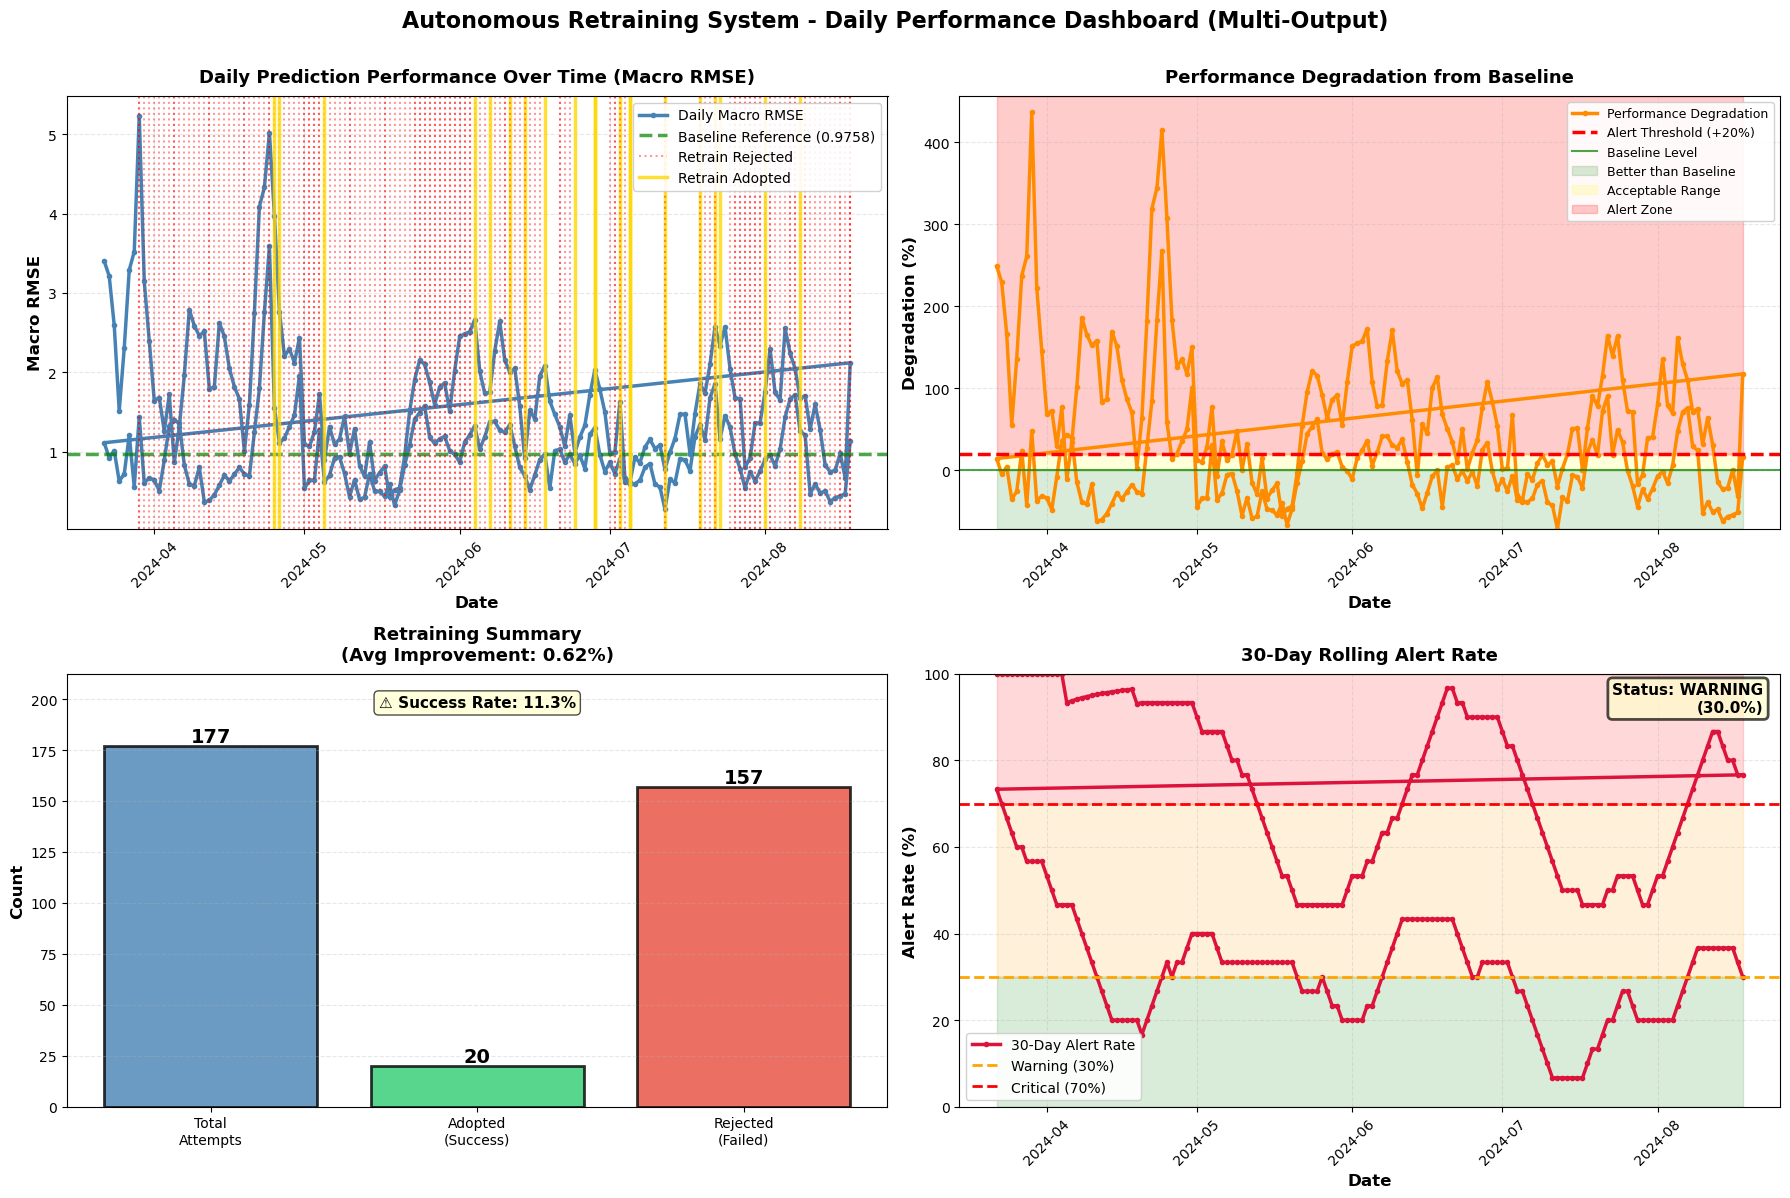


DAILY PERFORMANCE DASHBOARD SUMMARY (Multi-Output)
Total log entries: 300 (monitoring period)
Current Macro RMSE: 1.1324
Baseline Macro RMSE: 0.9758
Current degradation: 16.04%

Retraining Statistics:
  Total attempts: 177
  Adopted: 20 (11.3%)
  Rejected: 157 (88.7%)


Generating drift detection chart...
Drift detected in 40/45 features
Drift detection chart saved to drift_detection.png


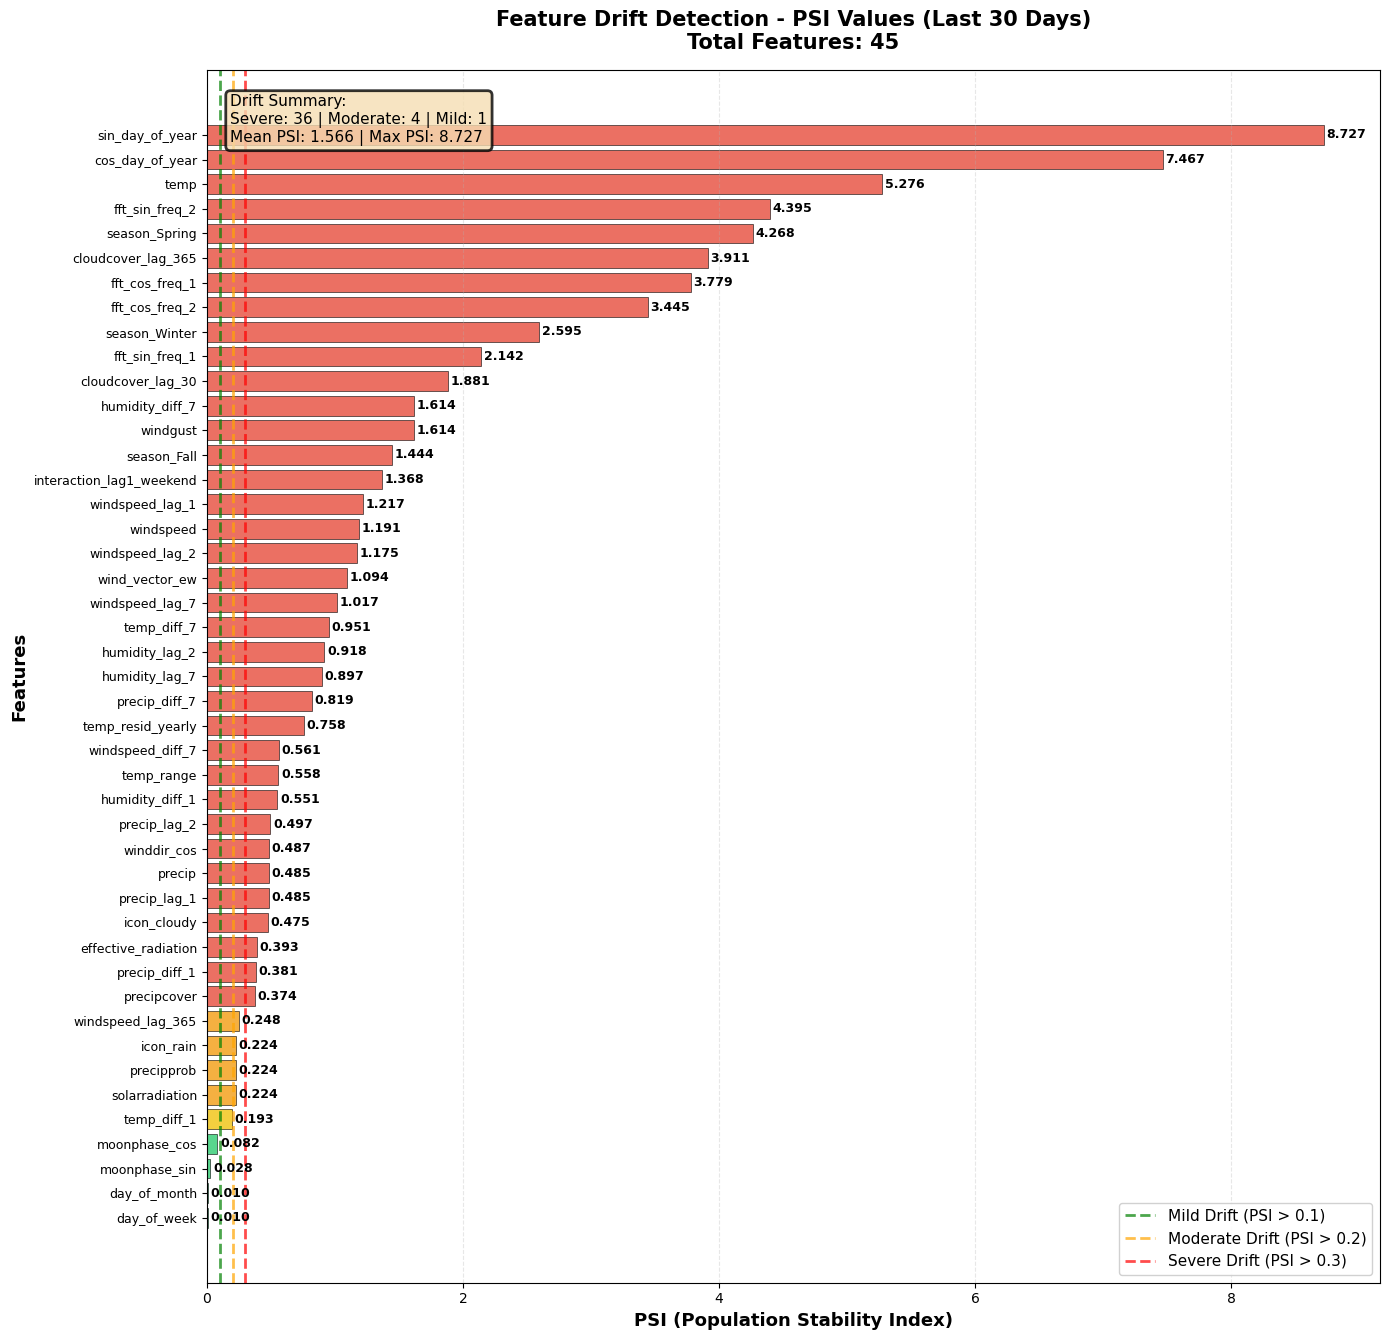


PSI DRIFT DETECTION - Last 30 Days
Total features: 45
  - Severe drift (PSI > 0.3):   36 features
  - Moderate drift (0.2-0.3):   4 features
  - Mild drift (0.1-0.2):       1 features
  - Minimal drift (< 0.1):      4 features

Top 5 highest PSI:
  1. sin_day_of_year: 8.7271
  2. cos_day_of_year: 7.4667
  3. temp: 5.2764
  4. fft_sin_freq_2: 4.3952
  5. season_Spring: 4.2682


Generating performance trends...
Performance chart saved to performance_trends.png


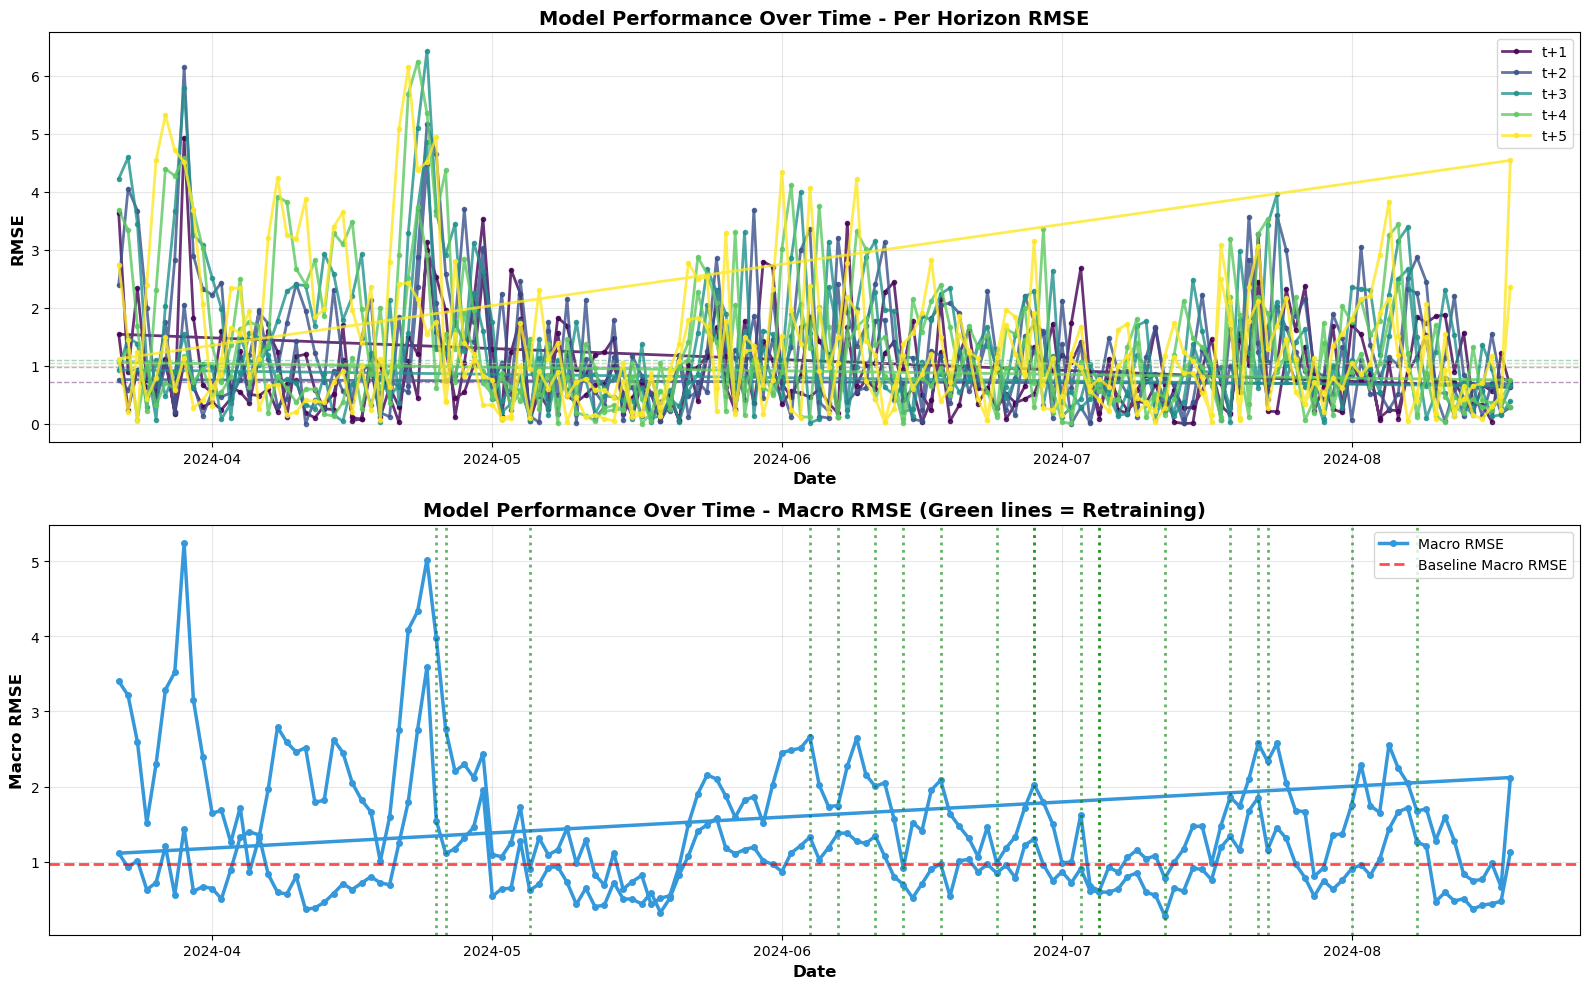


ALL VISUALIZATIONS GENERATED

Generated files:
  • autonomous_retraining_dashboard.png
  • drift_detection.png
  • performance_trends.png


In [77]:
# Generate comprehensive report
print("\n" + "="*80)
print("GENERATING FINAL REPORT")
print("="*80)

report = retraining_manager.generate_report()
print(report)

# Visualize performance dashboard
print("\nGenerating performance dashboard...")
retraining_manager.visualize_performance_dashboard(
    save_path='autonomous_retraining_dashboard.png'
)

# Visualize drift detection
print("\nGenerating drift detection chart...")
retraining_manager.visualize_drift_detection(
    save_path='drift_detection.png', 
    window_days=30
)

# Visualize performance over time
print("\nGenerating performance trends...")
retraining_manager.visualize_performance_over_time(
    save_path='performance_trends.png'
)

print("\n" + "="*80)
print("ALL VISUALIZATIONS GENERATED")
print("="*80)
print("\nGenerated files:")
print("  • autonomous_retraining_dashboard.png")
print("  • drift_detection.png")
print("  • performance_trends.png")
print("="*80)
